- xgboost 1.1.0
- numpy 1.17.2
- pandas
- matplotlib
- seaborn
- pickle
- 已有文件夹：
`Hive`(人工蜂群封装代码),`输入csv`,`整合后csv`,`输出图片`,`models`(存储的模型)

# 导入模块

In [52]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.signal import medfilt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score,f1_score,\
roc_curve, auc,log_loss,roc_auc_score,confusion_matrix,classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold,train_test_split, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict

from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from Hive import Hive

# 数据集制作

数据集制作过程在`第6章代码`中，直接使用输出后的表格文件`单砂体标签数据V3_0.csv`，不再赘述

# 定义输入输出

In [2]:
ori_csv = pd.read_csv('./输入csv/单砂体标签数据V3_0.csv',encoding='utf-8')
#填充空值
ori_csv = ori_csv.fillna(0)
#第6章代码中使用0填充统一各井厚度，此处除去0填充部分
ori_data = ori_csv[ori_csv['SSB']!=0].reset_index(drop=True)

## 两种数据划分模式
- I 所有井均作为数据集
- II 24口岩心井作为数据集

In [81]:
#随机选择训练井和测试井，第一种是所有井，以20%和80%分割
random.seed(0)
all_well = list(ori_data.WELL_ID.unique())
all_well_num = len(all_well)
random.shuffle(all_well)
cut = int(all_well_num*0.8)
train_names = all_well[:cut]
test_names = all_well[cut:]

In [58]:
#第二种是指定训练井和测试井
train_names = ['ZJ65','DP10','罗37-23','罗40-31','罗检34-281','罗34-31','罗37-36','罗检34-364',
              '罗41-37','罗33-371','罗加36-384','DP3','罗37-42','罗24-32','罗28-39','罗加32-44','罗28-47',
              '罗22-44','ZJ47','镰125']
test_names = ['罗635-29','罗31-34','罗检36-361','罗检38-365']

## 新增列，准备函数

In [82]:
#新增列，用于提出隔夹层实验
def get_chuc(row):
    #SSB=‘Single sand body’，锁定在SSB这列
    ssb = row['SSB']
    #如果砂层标记为7，那么就标记为0，否则标为1
    if ssb == 7:
        M = 0
    else:
        M = 1
    return M

#新增相对深度
def make_relative_depth(wells_df):
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['WELL_ID'])
    #对每口井增加相对深度一列
    for key in grouped.groups.keys():
        
        this_well = grouped.get_group(key)
        depth_start = this_well['DEPTH'].values[0]
        depth = this_well['DEPTH']
        relative_depth = depth-depth_start
        this_well['R_DEPTH'] = relative_depth

        new_df = new_df.append(this_well) 
    
    new_df = new_df.sort_index()
    #new_df_curves = new_df.drop(['DEPTH','WELL_ID'],axis=1)
    return new_df

#求一阶导，用来表示斜率，反映曲线的变化
def make_gradient_vars(wells_df,logs):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['WELL_ID'])
    #对每口井
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['DEPTH']
        temp_df = pd.DataFrame()
        #1 深度
        temp_df['DEPTH'] = depth
        #2 井名
        temp_df['WELL_ID'] = key
        #对每条曲线添加斜率特征
        for log in logs:
            temp_data = grouped.get_group(key)[log]
            temp_df[log + 'grad'] = np.gradient(temp_data)
        new_df = new_df.append(temp_df) 
    
    new_df = new_df.sort_index()
    new_df_curves = new_df.drop(['DEPTH','WELL_ID'],axis=1)
    return new_df_curves,new_df

In [83]:
#制造一个储层列，用于分别储层与隔夹层
ori_data.loc[:,'CHUC'] = ori_data.apply(lambda row: get_chuc(row), axis=1)
#制造一个列，返回相对深度
ori_data = make_relative_depth(ori_data)
#求取曲线的导函数grad
CHOSEN_CURVE = ['GR','SP','RT','AC','SH','POR','PERM','SW']
gradient_df1,_= make_gradient_vars(wells_df=ori_data, logs=CHOSEN_CURVE)
#after_data合并了原始数据和一阶导
after_data = pd.concat([ori_data,gradient_df1],axis=1)
# 第一次运行时，保存一下
# after_data.to_csv('./整合后csv/190口单砂体数据.csv',encoding='utf-8-sig',index=None)

In [61]:
#这个地方展示时使用了24口岩心井
core_data = after_data[after_data['WELL_ID'].isin(train_names+test_names)].reset_index(drop=True)
#这里第一次运行时，保存一次岩心井数据
# core_data.to_csv('./整合后csv/单砂体岩心井数据.csv',encoding='utf-8-sig',index=None)
train_data = after_data[after_data['WELL_ID'].isin(train_names)].reset_index(drop=True)
test_data = after_data[after_data['WELL_ID'].isin(test_names)].reset_index(drop=True)
train_labels = train_data.SSB.values
test_labels = test_data.SSB.values

- 实验分为两阶段：剔除隔夹层与单砂体识别
- 首先生成一列表示储层与隔夹层分类的列`CHUC`
- `SSB`列为*7* 表示是`隔夹层`，否则为`储层`，利用lambda函数快速实现

# 一些数据展示

## 储层与隔夹层交会图

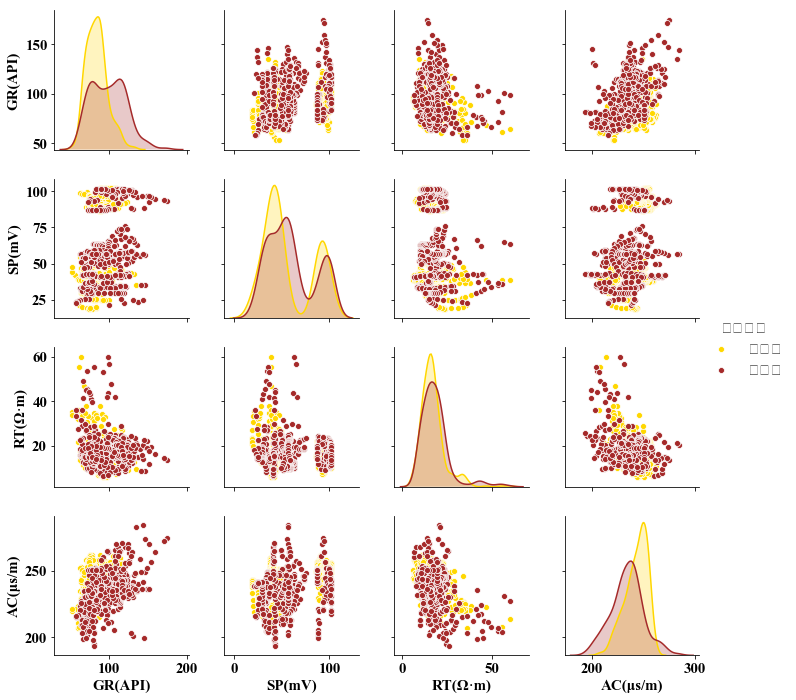

In [61]:
font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':15
}
mpl.rc("font", **font)
facies_colors = ['brown', 'gold']
facies_labels = ['隔夹层', '单砂体']

#调色盘
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
    
def label_facies(row, labels):
    return labels[row['CHUC']]
    
after_data.loc[:,'划分类别'] = after_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

cross_plot_data = test_data
cross_plot = cross_plot_data[['GR','SP','RT','AC','划分类别']]
cross_plot.columns=['GR(API)','SP(mV)','RT(Ω·m)','AC(μs/m)','划分类别']

sns.set(style="ticks", color_codes=True)
fig =sns.pairplot(cross_plot,size=3.5,
             hue='划分类别', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))
#mpl.rcParams.update(inline_rc)
# 保存交会图
fig.savefig('./输出图片/交会图.jpg',dpi = 300)

不太明显，后期展示的时候可以挑选区别较大的井展示

## 画采样点个数柱状图

In [17]:
#统计各元素数字总数，用来表示各层的层厚
def countX(dst, x):
    count = 0
    for point in dst:
        if (point == x):
            count = count + 1
    return count

In [27]:
#统计各层采样点数
train_c1 = countX(train_labels,1)
train_c2 = countX(train_labels,2)
train_c3 = countX(train_labels,3)
train_c4 = countX(train_labels,4)
train_c5 = countX(train_labels,5)
train_c6 = countX(train_labels,6)
train_c7 = countX(train_labels,7)

test_c1 = countX(test_labels,1)
test_c2 = countX(test_labels,2)
test_c3 = countX(test_labels,3)
test_c4 = countX(test_labels,4)
test_c5 = countX(test_labels,5)
test_c6 = countX(test_labels,6)
test_c7 = countX(test_labels,7)

TRAIN1,TRAIN2,TEST1,TEST2分别表示第一张图和第二张图的训练、测试集的采样点数

Text(0.5, 70.43854166666671, '')

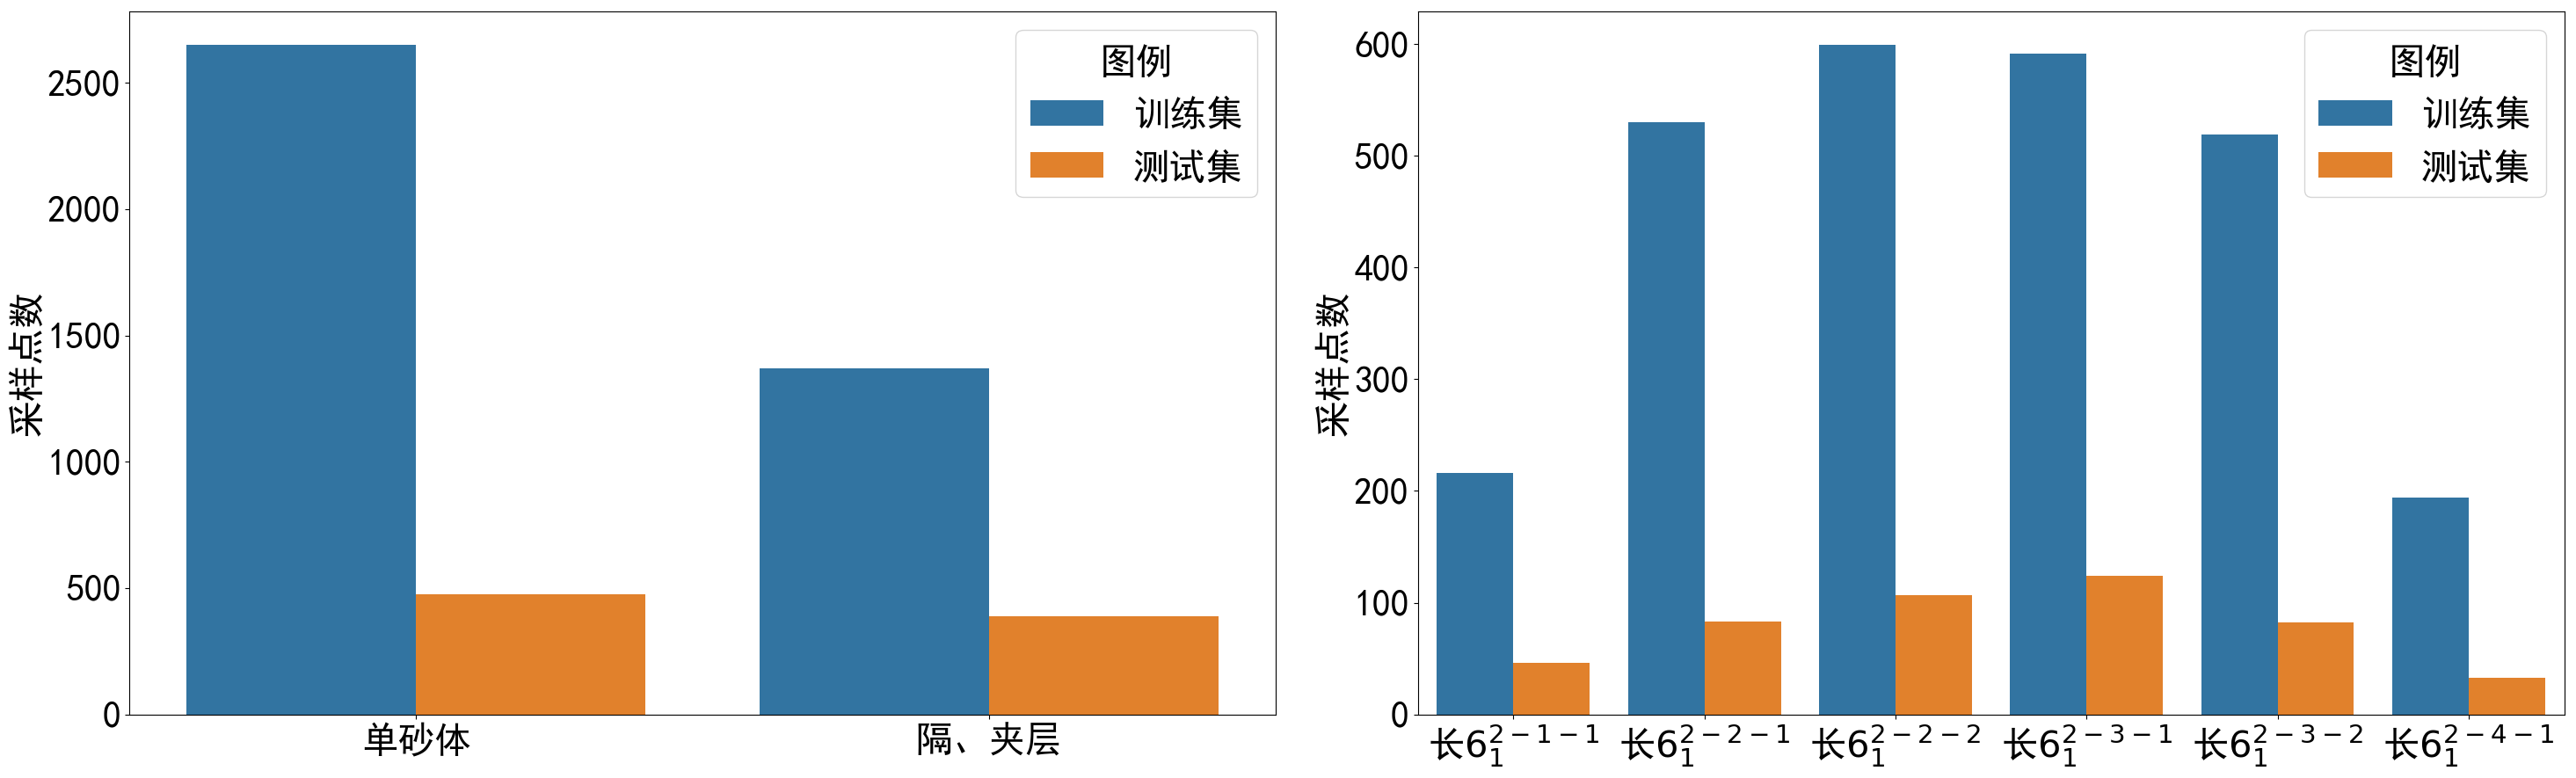

In [28]:
DANST = ['单砂体']*(train_c1+train_c2+train_c3+train_c4+train_c5+train_c6)  #(2960-175)*1.25=3481
GEJIAC = ['隔、夹层']*train_c7

dst1 = [r'长$6_1^{2-1-1}$']*train_c1
dst2= [r'长$6_1^{2-2-1}$']*train_c2
dst3= [r'长$6_1^{2-2-2}$']*train_c3
dst4= [r'长$6_1^{2-3-1}$']*train_c4
dst5= [r'长$6_1^{2-3-2}$']*train_c5
dst6= [r'长$6_1^{2-4-1}$']*train_c6

TRAIN1 = []
TRAIN1.extend(DANST)
TRAIN1.extend(GEJIAC)

TRAIN2 = []
TRAIN2.extend(dst1)
TRAIN2.extend(dst2)
TRAIN2.extend(dst3)
TRAIN2.extend(dst4)
TRAIN2.extend(dst5)
TRAIN2.extend(dst6)

TRAIN = pd.DataFrame([TRAIN1,TRAIN2]).T
TRAIN.columns = ['剔除隔、夹层','单砂体识别']
XUNLIAN = TRAIN
XUNLIAN['图例'] = '训练集'

DANST = ['单砂体']*(test_c1+test_c2+test_c3+test_c4+test_c5+test_c6)
GEJIAC = ['隔、夹层']*test_c7

dst1 = [r'长$6_1^{2-1-1}$']*test_c1
dst2= [r'长$6_1^{2-2-1}$']*test_c2
dst3= [r'长$6_1^{2-2-2}$']*test_c3
dst4= [r'长$6_1^{2-3-1}$']*test_c4
dst5= [r'长$6_1^{2-3-2}$']*test_c5
dst6= [r'长$6_1^{2-4-1}$']*test_c6

TEST1 = []
TEST1.extend(DANST)
TEST1.extend(GEJIAC)

TEST2 = []
TEST2.extend(dst1)
TEST2.extend(dst2)
TEST2.extend(dst3)
TEST2.extend(dst4)
TEST2.extend(dst5)
TEST2.extend(dst6)

TEST = pd.DataFrame([TEST1,TEST2]).T
TEST.columns =['剔除隔、夹层','单砂体识别']
CESHI = TEST
CESHI['图例'] = '测试集'

TU = pd.concat([XUNLIAN,CESHI],axis=0)

font = {
    'family':'SimHei',
    #'weight':'bold',
    'size':30
}

mpl.rc("font", **font)
plt.figure(figsize=(30,10),dpi=100)
plt.subplot(121)   #subplot(行，列，第几个)
# sns.set()
sns.countplot(x='剔除隔、夹层',hue="图例",data=TU,#palette=color_map1
             )
plt.tight_layout()
plt.ylabel('采样点数')
plt.xlabel('')

plt.subplot(122)
ax = sns.countplot(x='单砂体识别',hue="图例", data=TU,#palette=color_map2
             )
ax.set_xticklabels(ax.get_xticklabels(), rotation=0,)
plt.tight_layout()
plt.ylabel('采样点数')
plt.xlabel('')
# plt.show()
# 保存柱状图
# plt.savefig('./输出图片/柱状图.jpg')

## 箱装图查看各单砂体数据分布

In [40]:
#筛选出各单砂体的测井数据
dst1 = train_data[train_data['SSB']==1]
dst2 = train_data[train_data['SSB']==2]
dst3 = train_data[train_data['SSB']==3]
dst4 = train_data[train_data['SSB']==4]
dst5 = train_data[train_data['SSB']==5]
dst6 = train_data[train_data['SSB']==6]

#这里用相对深度
DEPTH = []
DEPTH.extend([dst1['R_DEPTH'].values,dst2['R_DEPTH'].values,dst3['R_DEPTH'].values,
              dst4['R_DEPTH'].values,dst5['R_DEPTH'].values,dst6['R_DEPTH'].values])

In [42]:
#深度再加上3种物性参数
CURVES = ['GR','SP','RT','AC','POR','PERM','SW']

GR = []
SP = []
RT = []
AC = []
POR = []
PERM = []
SW = []

ALL_data = [GR,SP,RT,AC,POR,PERM,SW]

for i in range(len(CURVES)):
#     print('NOW THE CURVE IS',LOGS[i])
    curve=CURVES[i]
    ALL_data[i].extend([dst1[curve].values,dst2[curve].values,dst3[curve].values,
                        dst4[curve].values,dst5[curve].values,dst6[curve].values])

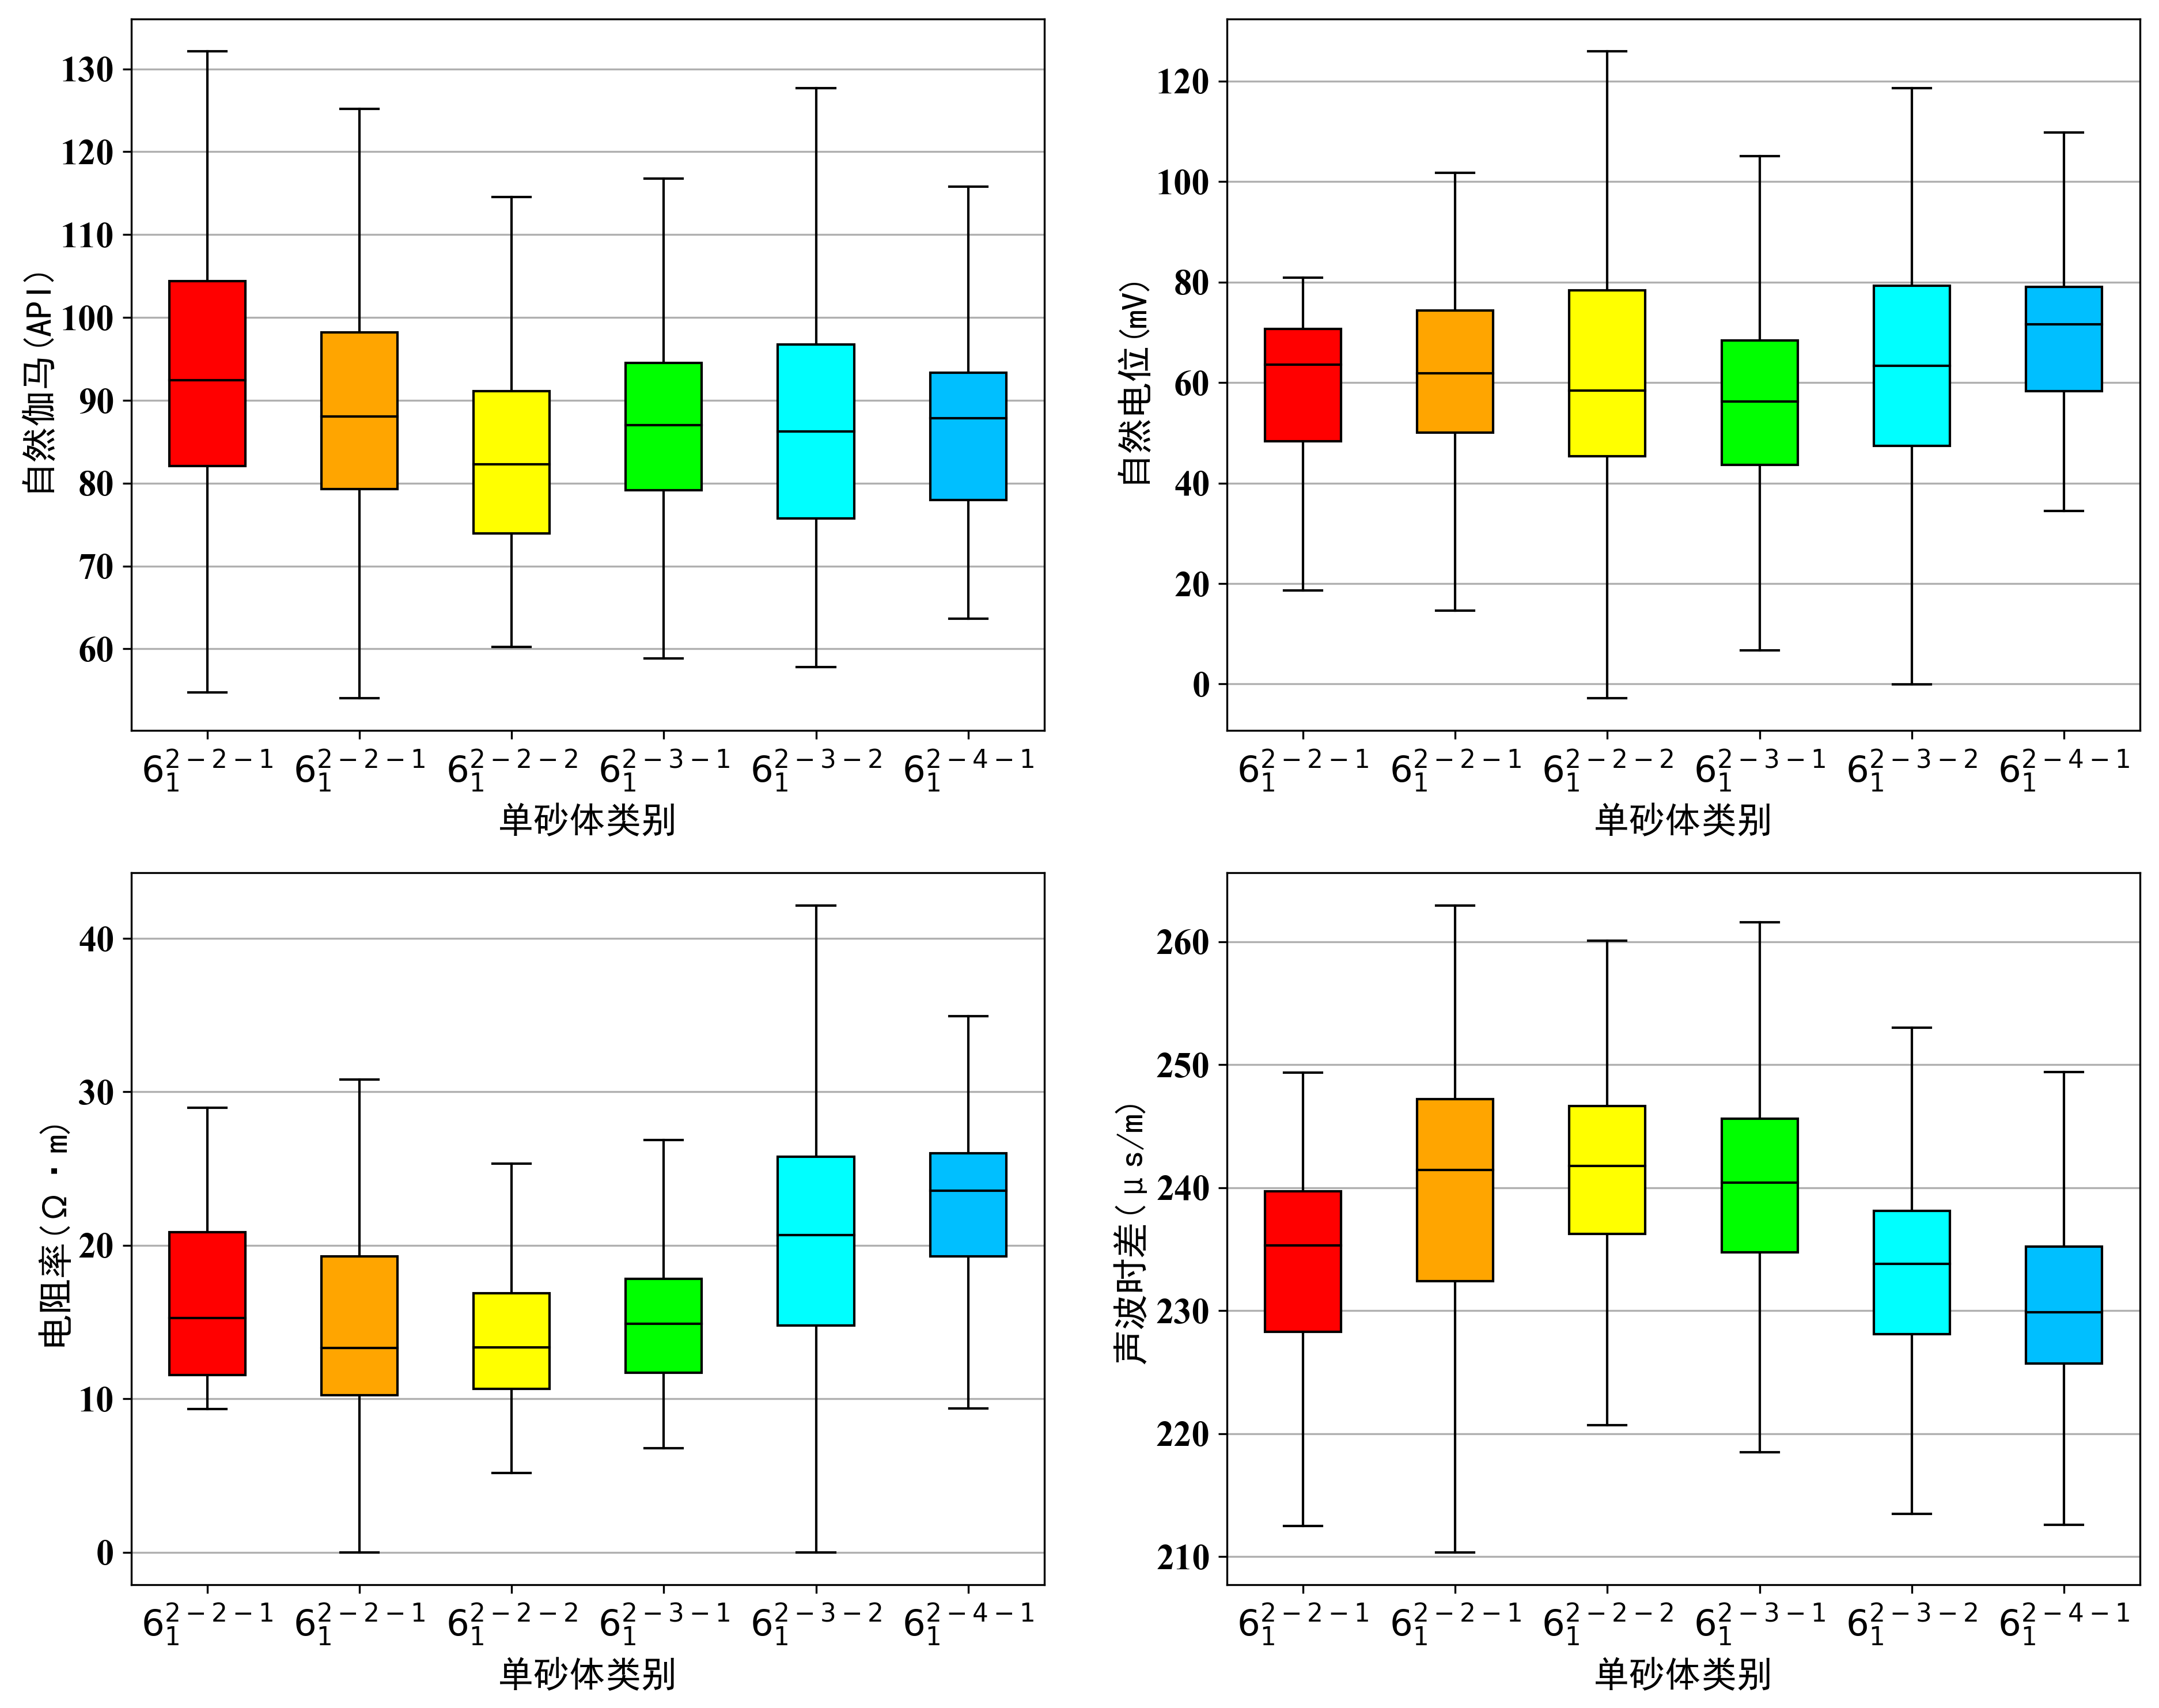

In [45]:
# 先是4类测井曲线
font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':15
}
font2 = {
    'family':'SimHei',
    #'weight':'bold',
    'size':15
}
mpl.rc("font", **font)
#设置显示的横坐标刻度
labels = r'$6_1^{2-2-1}$',r'$6_1^{2-2-1}$',r'$6_1^{2-2-2}$',r'$6_1^{2-3-1}$',\
r'$6_1^{2-3-2}$',r'$6_1^{2-4-1}$'

fig, ax = plt.subplots(2,2,figsize=(15,12),dpi=300)
ax1=ax[0][0]
ax2=ax[0][1]
ax3=ax[1][0]
ax4=ax[1][1]

bplot1 = ax1.boxplot(GR,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax1.set_ylabel('自然伽马(API)',font2)
bplot2 = ax2.boxplot(SP,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax2.set_ylabel('自然电位(mV)',font2)
bplot3 = ax3.boxplot(RT,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax3.set_ylabel('电阻率(Ω·m)',font2)

bplot4 = ax4.boxplot(AC,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax4.set_ylabel('声波时差(μs/m)',font2)

colors =   ['RED','orange','yellow','lime','cyan','deepskyblue']
for bplot in (bplot1, bplot2,bplot3,bplot4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
#坐标轴设置
for ax in [ax1, ax2,ax3,ax4]:
    ax.yaxis.grid(True)
    ax.set_xlabel('单砂体类别',font2)
#保存图片    
plt.savefig('./输出图片/箱状图1.jpg')

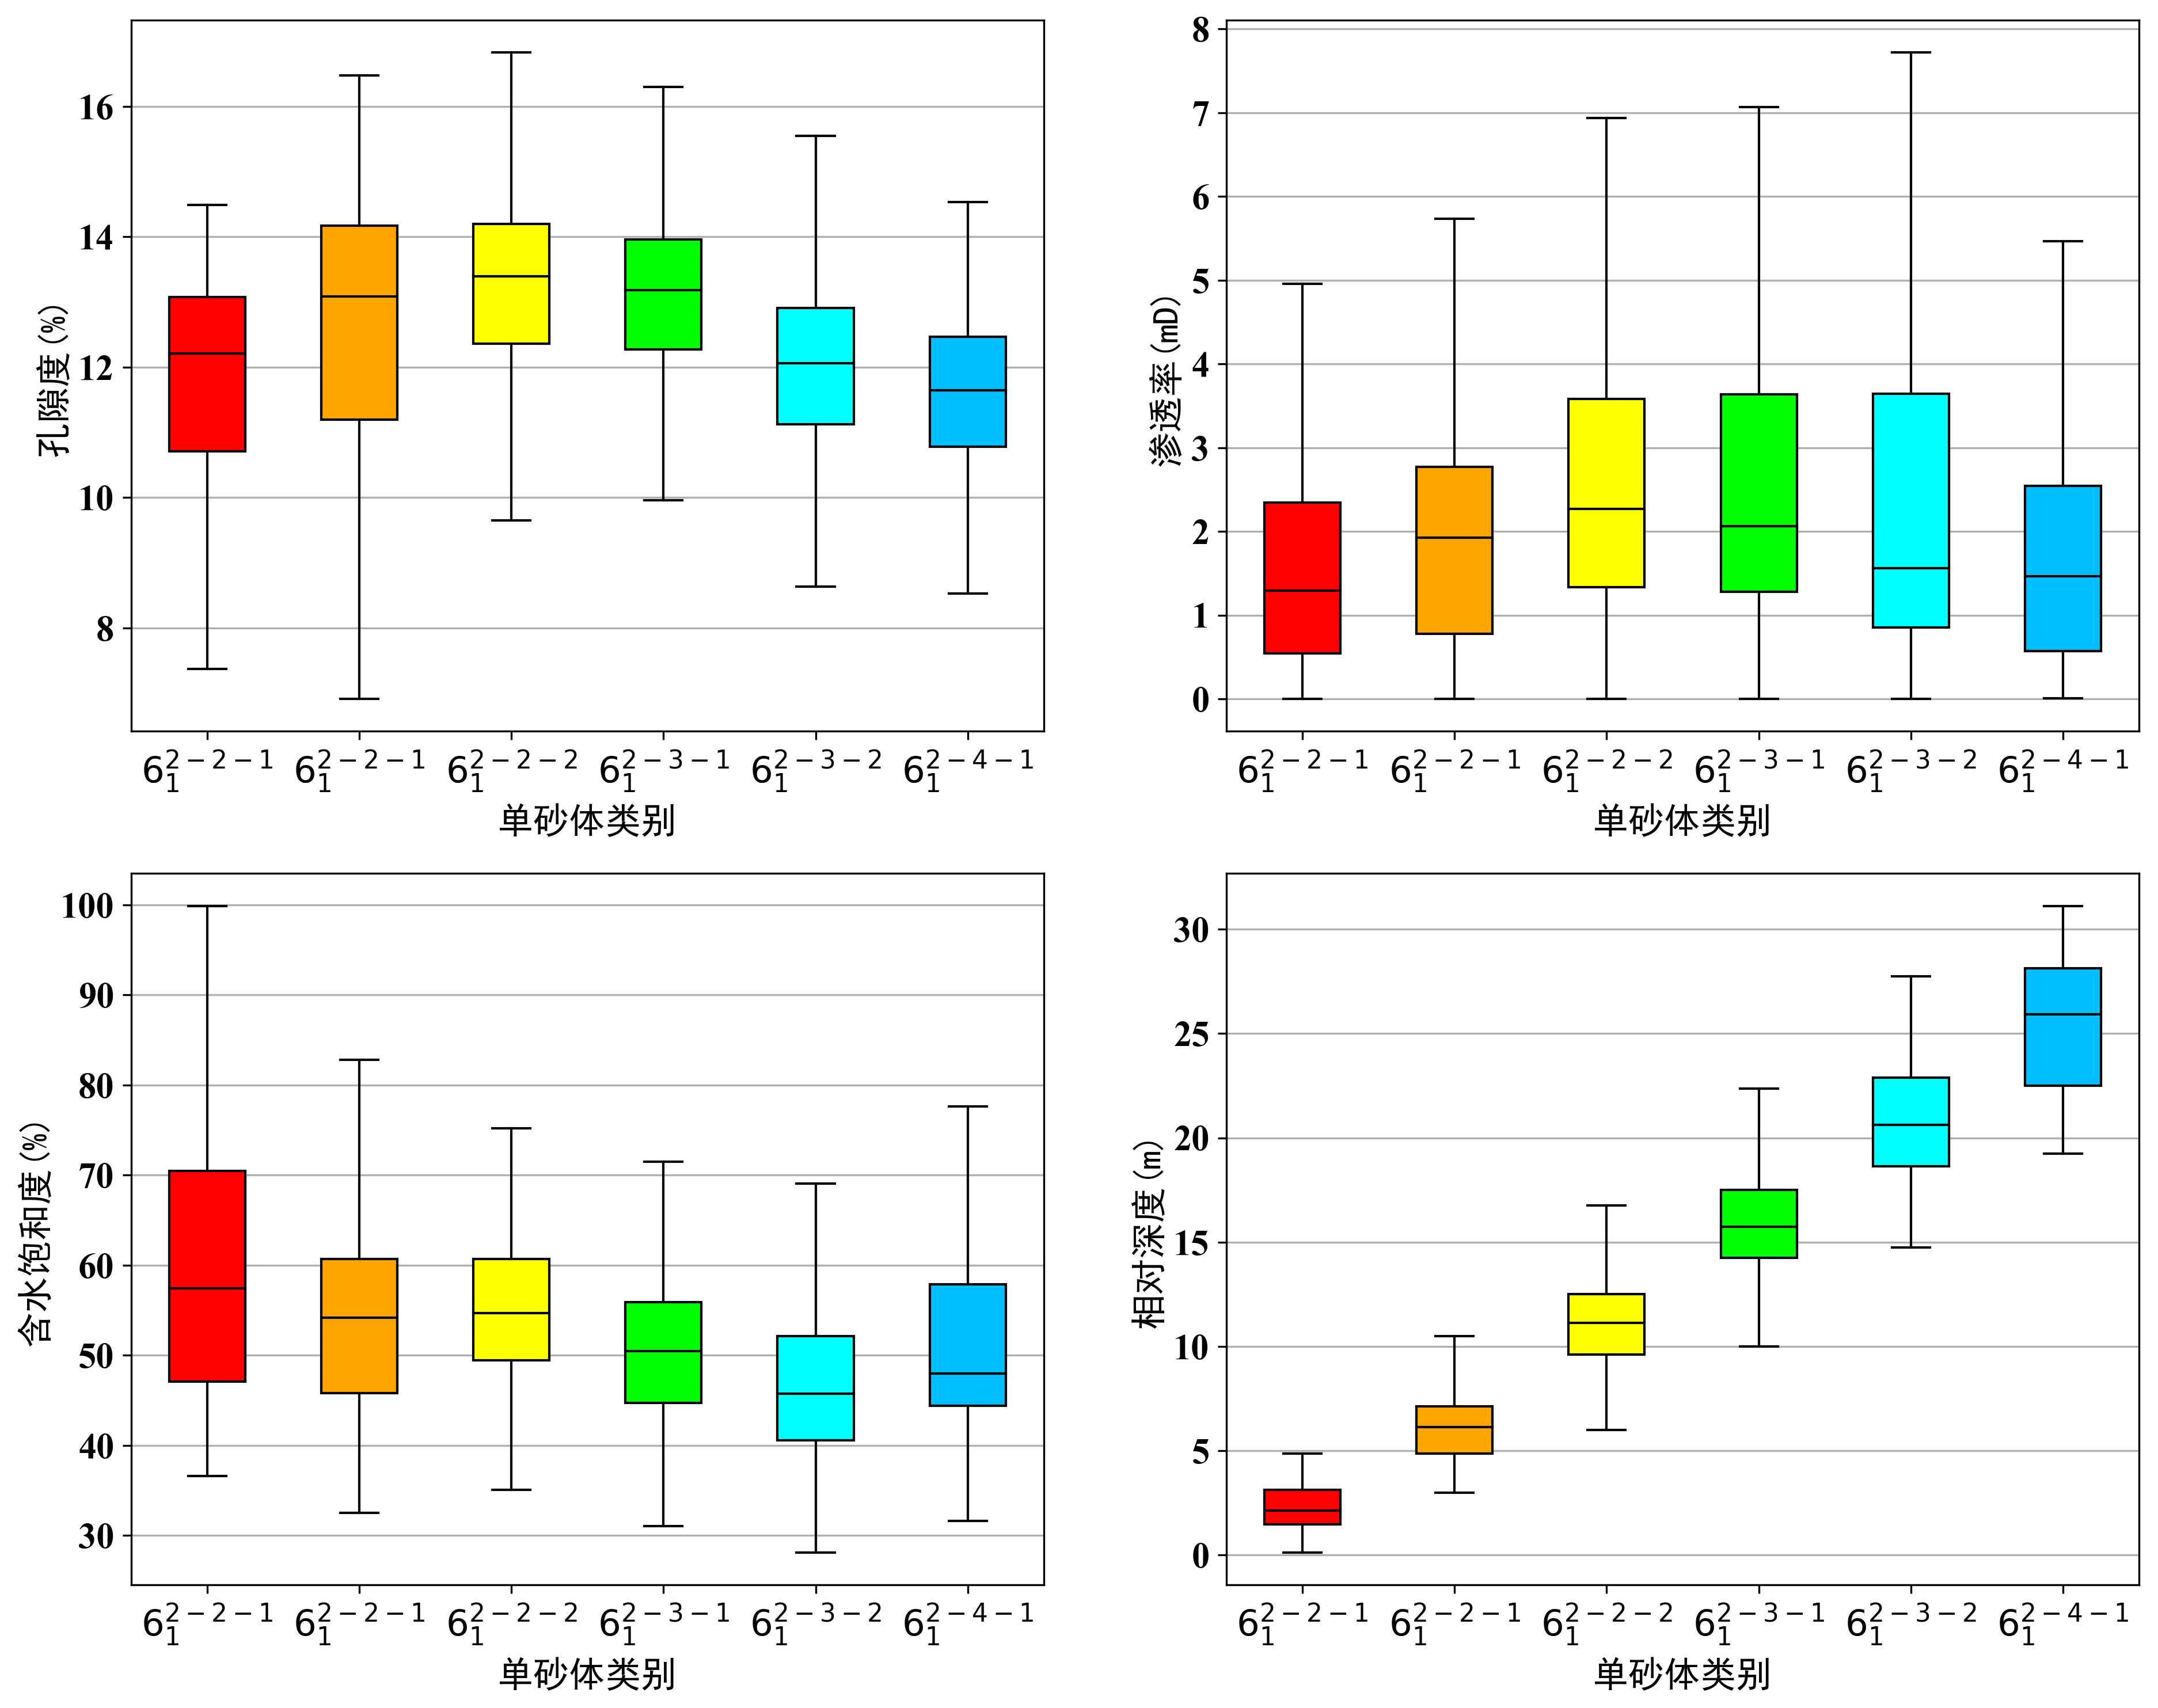

In [47]:
#然后是3类物性参数+相对深度
font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':15
}
font2 = {
    'family':'SimHei',
    #'weight':'bold',
    'size':15
}
mpl.rc("font", **font)

fig, ax = plt.subplots(2,2,figsize=(15,12),dpi=300)
ax1=ax[0][0]
ax2=ax[0][1]
ax3=ax[1][0]
ax4=ax[1][1]

bplot1 = ax1.boxplot(POR,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax1.set_ylabel('孔隙度(%)',font2)
bplot2 = ax2.boxplot(PERM,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax2.set_ylabel('渗透率(mD)',font2)
bplot3 = ax3.boxplot(SW,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax3.set_ylabel('含水饱和度(%)',font2)

bplot4 = ax4.boxplot(DEPTH,medianprops={'color':'black'},showfliers=False,
                         patch_artist=True, labels = labels)
ax4.set_ylabel('相对深度(m)',font2)

colors =   ['RED','orange','yellow','lime','cyan','deepskyblue']
for bplot in (bplot1, bplot2,bplot3,bplot4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
#坐标轴设置
for ax in [ax1,ax2,ax3,ax4]:
    ax.yaxis.grid(True)
    ax.set_xlabel('单砂体类别',font2)
#保存图片    
plt.savefig('./输出图片/箱状图2.jpg')

# 阶段一：剔除隔夹层

## 设置输入、输出

In [7]:
drop_col = ['DEPTH','WELL_ID','CHUC','SSB']
#同样之后可以增加曲线的种类
chosen_curve = ['mm_GR','mm_SP','mm_RT','mm_AC','mm_SH']
curve_grad = ['GRgrad','SPgrad','RTgrad','ACgrad','SHgrad']

stage1_train = train_data[drop_col+chosen_curve]
stage1_test = test_data[drop_col+chosen_curve]
'''需要修改的地方是这个data'''
# data = stage1_data
stage1_trainX = train_data[chosen_curve+curve_grad]
stage1_trainY = train_data.CHUC.values
stage1_testX = test_data[chosen_curve+curve_grad]
stage1_testY = test_data.CHUC.values

## 准备函数（包括展示精度，保存、读取模型）

In [4]:
# 展示测试集预测精度
def show_results(clf,testX,testY):
    result = clf.predict(testX)
    test_prob = clf.predict_proba(testX)[:,1]
    print("Accuracy on test set:")
    print(accuracy_score(testY, result))
    print("Recall on test set:")
    print(recall_score(testY, result))
    print("auc_score on test set:")
    print(roc_auc_score(testY, test_prob))

# 存储模型
def save_model(clf,clfname):
    s=pickle.dumps(clf)
    f=open('./models'+'\\'+clfname+'.model', "wb+")
    f.write(s)
    f.close()
    print ("Save Done\n")
    
# 载入模型
def load_model(clfname):
    f=open('./models'+'\\'+clfname+'.model','rb')
    s=f.read()
    model=pickle.loads(s)
    return model 

## 建立模型并训练

### ABC-XGBoost

In [28]:
def run_abc_xgboost(lowBounds,upBounds,optimizer):
    #下限和上限都用列表
    model = Hive.BeeHive(lower = lowBounds, 
                         upper = upBounds ,  
                         fun       = optimizer,
                         numb_bees =  200       ,
                         max_itrs  =  2       ,)

    # runs model
    cost,sol = model.run()

    return cost,sol

def optimizer_xgb(params):
    #交叉验证的部分未做
    xgb = XGBClassifier(learning_rate =10 ** params[0],n_estimators = int(params[1]),
                         max_depth=int(params[2]),min_child_weight=params[3],
                         gamma=params[4],subsample=params[5],colcample_bytree=params[6]).fit(stage1_trainX, stage1_trainY)

    pred_proba = xgb.predict_proba(stage1_trainX)
    return log_loss(stage1_trainY,pred_proba)
    
#调参的范围
#learning_rate [0.001,1]
#n_estimators  [100,500]
#max_depth  [3,10]
#min_child_weight  [0,10]
#gamma  [0,1]
#subsample  [0,1]
#colcample_bytree  [0,1]
cost_xgb,sol = run_abc_xgboost([-3,100,3,0,0,0.5,0.5],[0,500,10,10,1,1,1],optimizer_xgb)

#使用最优参数获得最优化模型
ABC_xgb_1 = XGBClassifier(learning_rate =10 ** sol[0],n_estimators = int(sol[1]),
                         max_depth=int(sol[2]),min_child_weight=sol[3],
                         gamma=sol[4],subsample=sol[5],colcample_bytree=sol[6]).fit(stage1_trainX, stage1_trainY)
#展示结果
show_results(ABC_xgb_1,stage1_testX,stage1_testY)
#保存模型
save_model(ABC_xgb_1,'ABC_xgb_1')

[21:37:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:37:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:37:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:37:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:37:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:37:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:38:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:38:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:38:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:38:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:39:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:39:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:39:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:40:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:40:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:40:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:40:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:40:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:40:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:41:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:41:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:41:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:41:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:41:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:41:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:41:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:41:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:41:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:42:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:42:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:42:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:42:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:42:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:42:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:42:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:42:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:42:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:43:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:43:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:43:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:43:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:44:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:44:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:45:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[21:45:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:45:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

### GS-XGBoost

- 这个过程非常耗时；
- 并且作为对照实验，如果调参之后效果变得非常好，但是时间花费大，将很难解释哪个好；
- 所以以随缘设定的参数作为GS-XGBoost的结果

In [ ]:
param = {
    'learning_rate':[0.001,0.01,0.1,1],
    'n_estimators':[100,200,300,400,500],
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,10,1),
    'gamma':range(0,1,0.1),
    'subsample':range(0,1,0.1),
    'colcample_bytree':range(0,1,0.1),
}
clf = XGBClassifier()

grid_search = GridSearchCV(estimator=clf,
                           param_grid=param,
                           scoring='roc_auc',
                           n_jobs=8,
                           cv=5)
grid_search.fit(stage1_trainX, stage1_trainY)

print('params:{}\nscore:{}'.format(grid_search.best_params_,grid_search.best_score_))

In [26]:
GS_xgb_1 = XGBClassifier(learning_rate = 0.001, n_estimators=500, max_depth=6,
                          min_child_weight=5, gamma=0.5, subsample=0.8,
                          colsample_bytree=0.8, objective='binary:logistic',
                          nthread=4, scale_pos_weight=1, seed=27).fit(stage1_trainX, stage1_trainY)
#展示结果
show_results(GS_xgb_1,stage1_testX,stage1_testY)
#保存模型
save_model(GS_xgb_1,'GS_xgb_1')

Accuracy on test set:
0.7734104046242775
Recall on test set:
0.991578947368421
auc_score on test set:
0.8962699055330634
Save Done



### ABC-SVM

In [ ]:
def run_abc_svm(lowBounds,upBounds,optimizer):

    model = Hive.BeeHive(lower = lowBounds, # MUST BE A LIST !
                         upper = upBounds , # MUST BE A LIST ! 
                         fun       = optimizer ,
                         numb_bees =  200       ,
                         max_itrs  =  2       ,)

    # runs model
    cost,sol = model.run()
    return cost,sol

def optimizer_svm(params):

    SVM = svm.SVC(C=10 ** params[0], gamma=10 ** params[1],probability=True).fit(stage1_trainX, stage1_trainY)
    
    pred_proba = SVM.predict_proba(stage1_trainX)
    return log_loss(stage1_trainY,pred_proba)

# 惩罚因子C [0.1,100]
# 核函数平滑因子γ [0.1,10]
cost_svm,sol= run_abc_svm([-1,-1],[2,1],optimizer_svm)

In [31]:
ABC_svm_1 = svm.SVC(C=10 ** sol[0], gamma=10 ** sol[1],probability=True).fit(stage1_trainX, stage1_trainY)

show_results(ABC_svm_1,stage1_testX,stage1_testY)
save_model(ABC_svm_1,'ABC_svm_1')

Accuracy on test set:
0.545664739884393
Recall on test set:
0.9936842105263158
auc_score on test set:
0.7071093117408908
Save Done



### ABC-RF

In [33]:
def run_abc_rf(lowBounds,upBounds,optimizer):

    model = Hive.BeeHive(lower = lowBounds, # MUST BE A LIST !
                         upper = upBounds , # MUST BE A LIST ! 
                         fun       = optimizer ,
                         numb_bees =  200       ,
                         max_itrs  =  2       ,)
    # runs model
    cost,sol = model.run()

    return cost,sol

def optimizer_rf(params):

    rf = RandomForestClassifier(max_depth=params[0],min_weight_fraction_leaf=params[1],
                                  n_estimators = int(params[2])).fit(stage1_trainX, stage1_trainY)
    pred_proba = rf.predict_proba(stage1_trainX)
    return log_loss(stage1_trainY,pred_proba)
    

cost_rf,sol = run_abc_rf([3,0,10],[100,0.5,200],optimizer_rf)
ABC_rf_1 = RandomForestClassifier(max_depth=sol[0],min_weight_fraction_leaf=sol[1],
                                  n_estimators = int(sol[2])).fit(stage1_trainX, stage1_trainY)
show_results(ABC_rf_1,stage1_testX,stage1_testY)
save_model(ABC_rf_1,'ABC_rf_1')

EVALS:458
Accuracy on test set:
0.7988439306358381
Recall on test set:
0.9389473684210526
auc_score on test set:
0.8946234817813764
Save Done



## 画适应度图

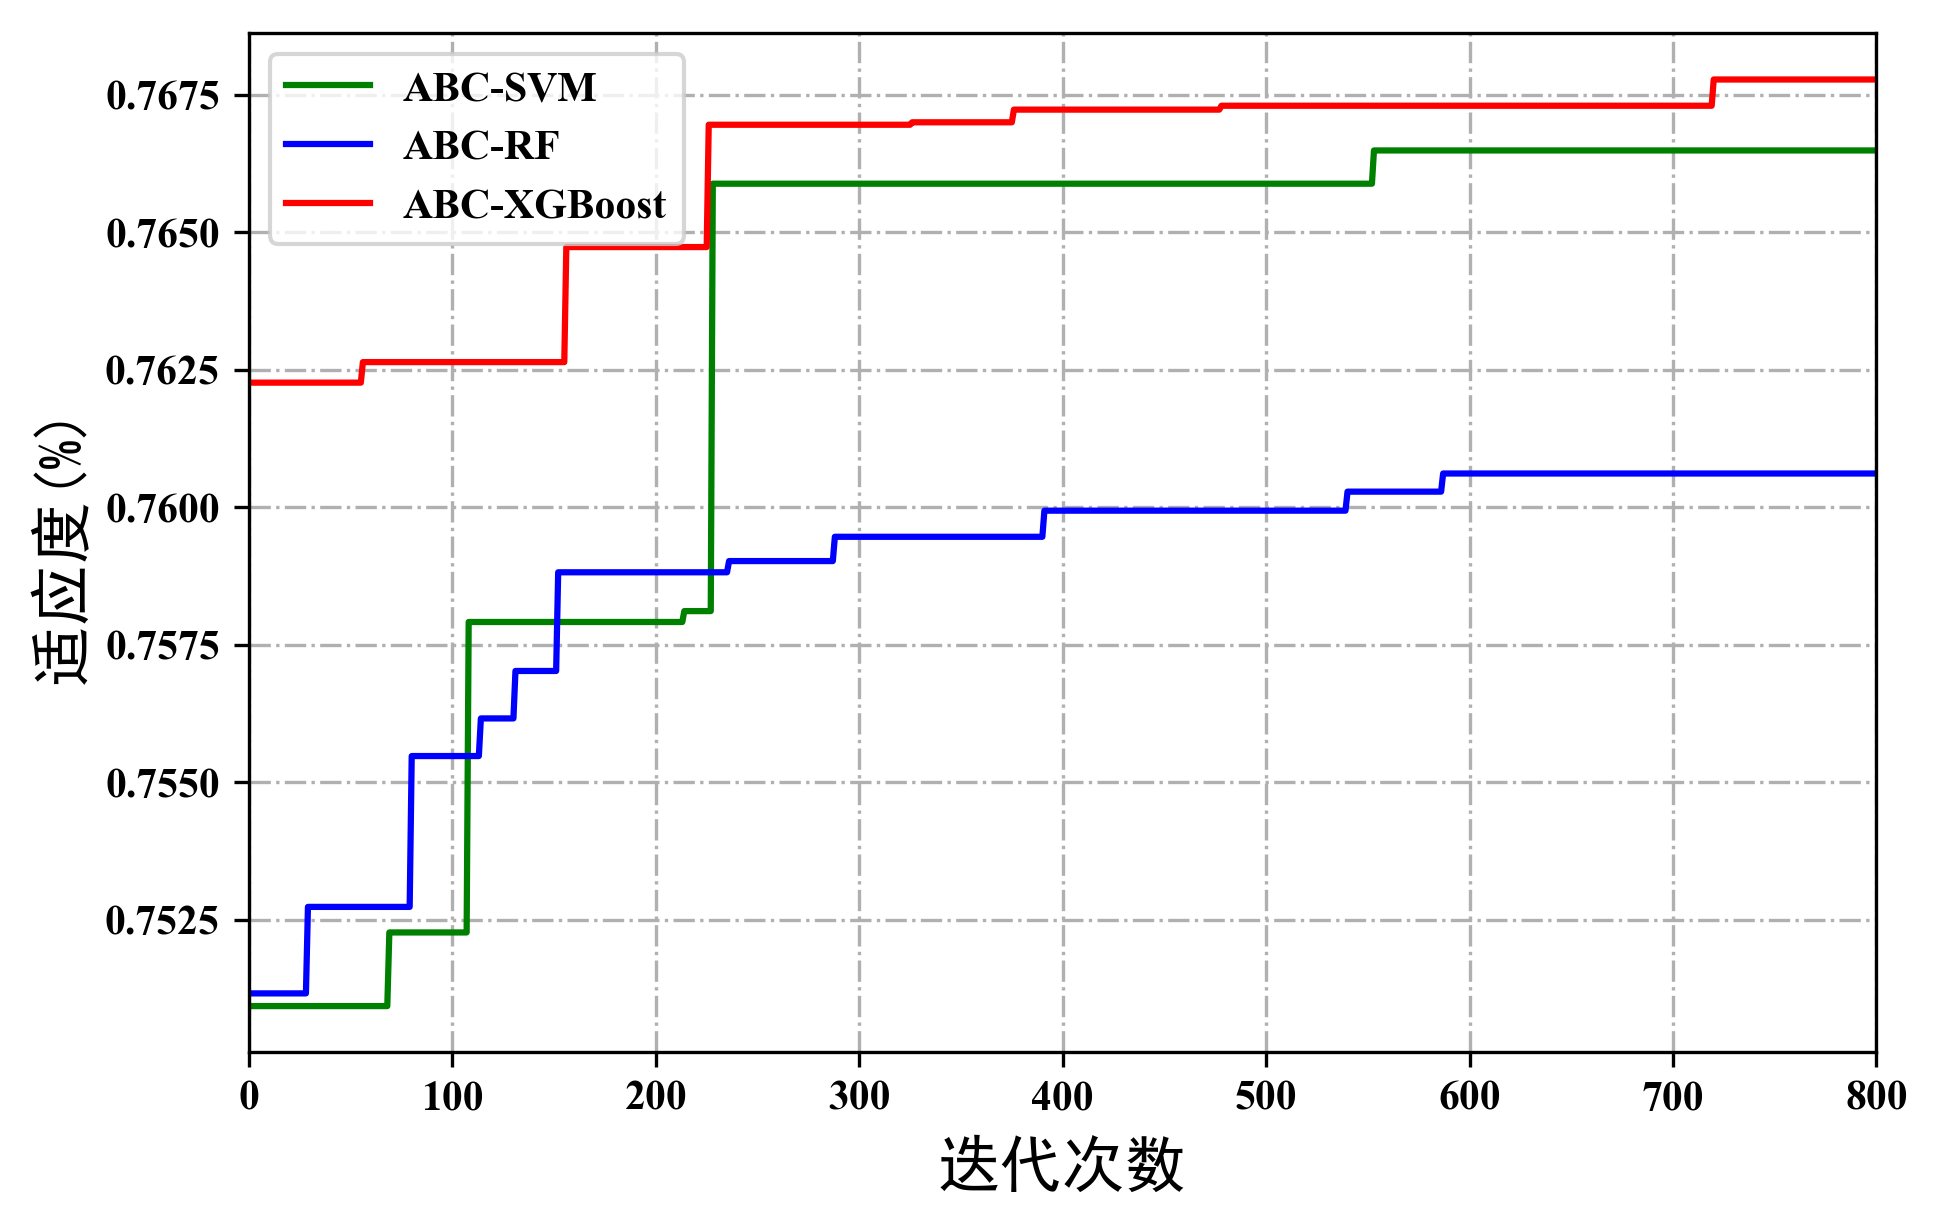

In [130]:
# FITNESS = pd.DataFrame([cost_xgb['best'],cost_svm['best'],cost_rf['best']]).T
# FITNESS.columns = ['XGB','SVM','RF']
#保存一下，如果之后有改动可以从这里重新作图
# FITNESS.to_csv("./输入csv/FITNESS.csv",encoding='utf-8-sig',index=None)
FITNESS = pd.read_csv('./输入csv/FITNESS.csv',encoding='gbk')
font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':15
}
font2 = {
    'family':'SimHei',
    #'weight':'bold',
    'size':15
}
mpl.rc("font", **font)
labels = ['ABC-SVM',"ABC-RF","ABC-XGBoost" ]
plt.figure(figsize=(7, 4.5),dpi=300);
#plt.plot(range(len(cost["best"])), [i-0.01 for i in cost['best']],color='red', label=labels[0])
plt.plot(range(len(FITNESS['SVM'])), 1/(1+FITNESS['SVM']),color='g' ,label=labels[0]);
plt.plot(range(len(FITNESS['RF'])), 1/(1+FITNESS['RF']),color='blue', label=labels[1]);
plt.plot(range(len(FITNESS['XGB'])), 1/(1+FITNESS['XGB']),color='red', label=labels[2])

plt.xlim([0,800]);
# plt.yticks([0.305, 0.310, 0.315,0.320, 0.325,0.330],
#   [0.28, 0.29, 0.30, 0.31, 0.32,0.33])
# plt.xticks([0, 200, 400, 600, 800],
#   [0, 100, 200, 300, 400])

plt.xlabel("迭代次数",font2);
plt.ylabel("适应度(%)",font2);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="best",fontsize=10);

plt.grid(linestyle='-.');
# plt.savefig('./输出图片/适应度函数图.jpg')
# plt.show()

## 载入模型——之后打开程序时可跳过训练过程

In [15]:
ABC_xgb_1 = load_model('ABC_xgb_1')
GS_xgb_1 = load_model('GS_xgb_1')
ABC_svm_1 = load_model('ABC_svm_1')
ABC_rf_1 = load_model('ABC_rf_1')

## ROC图

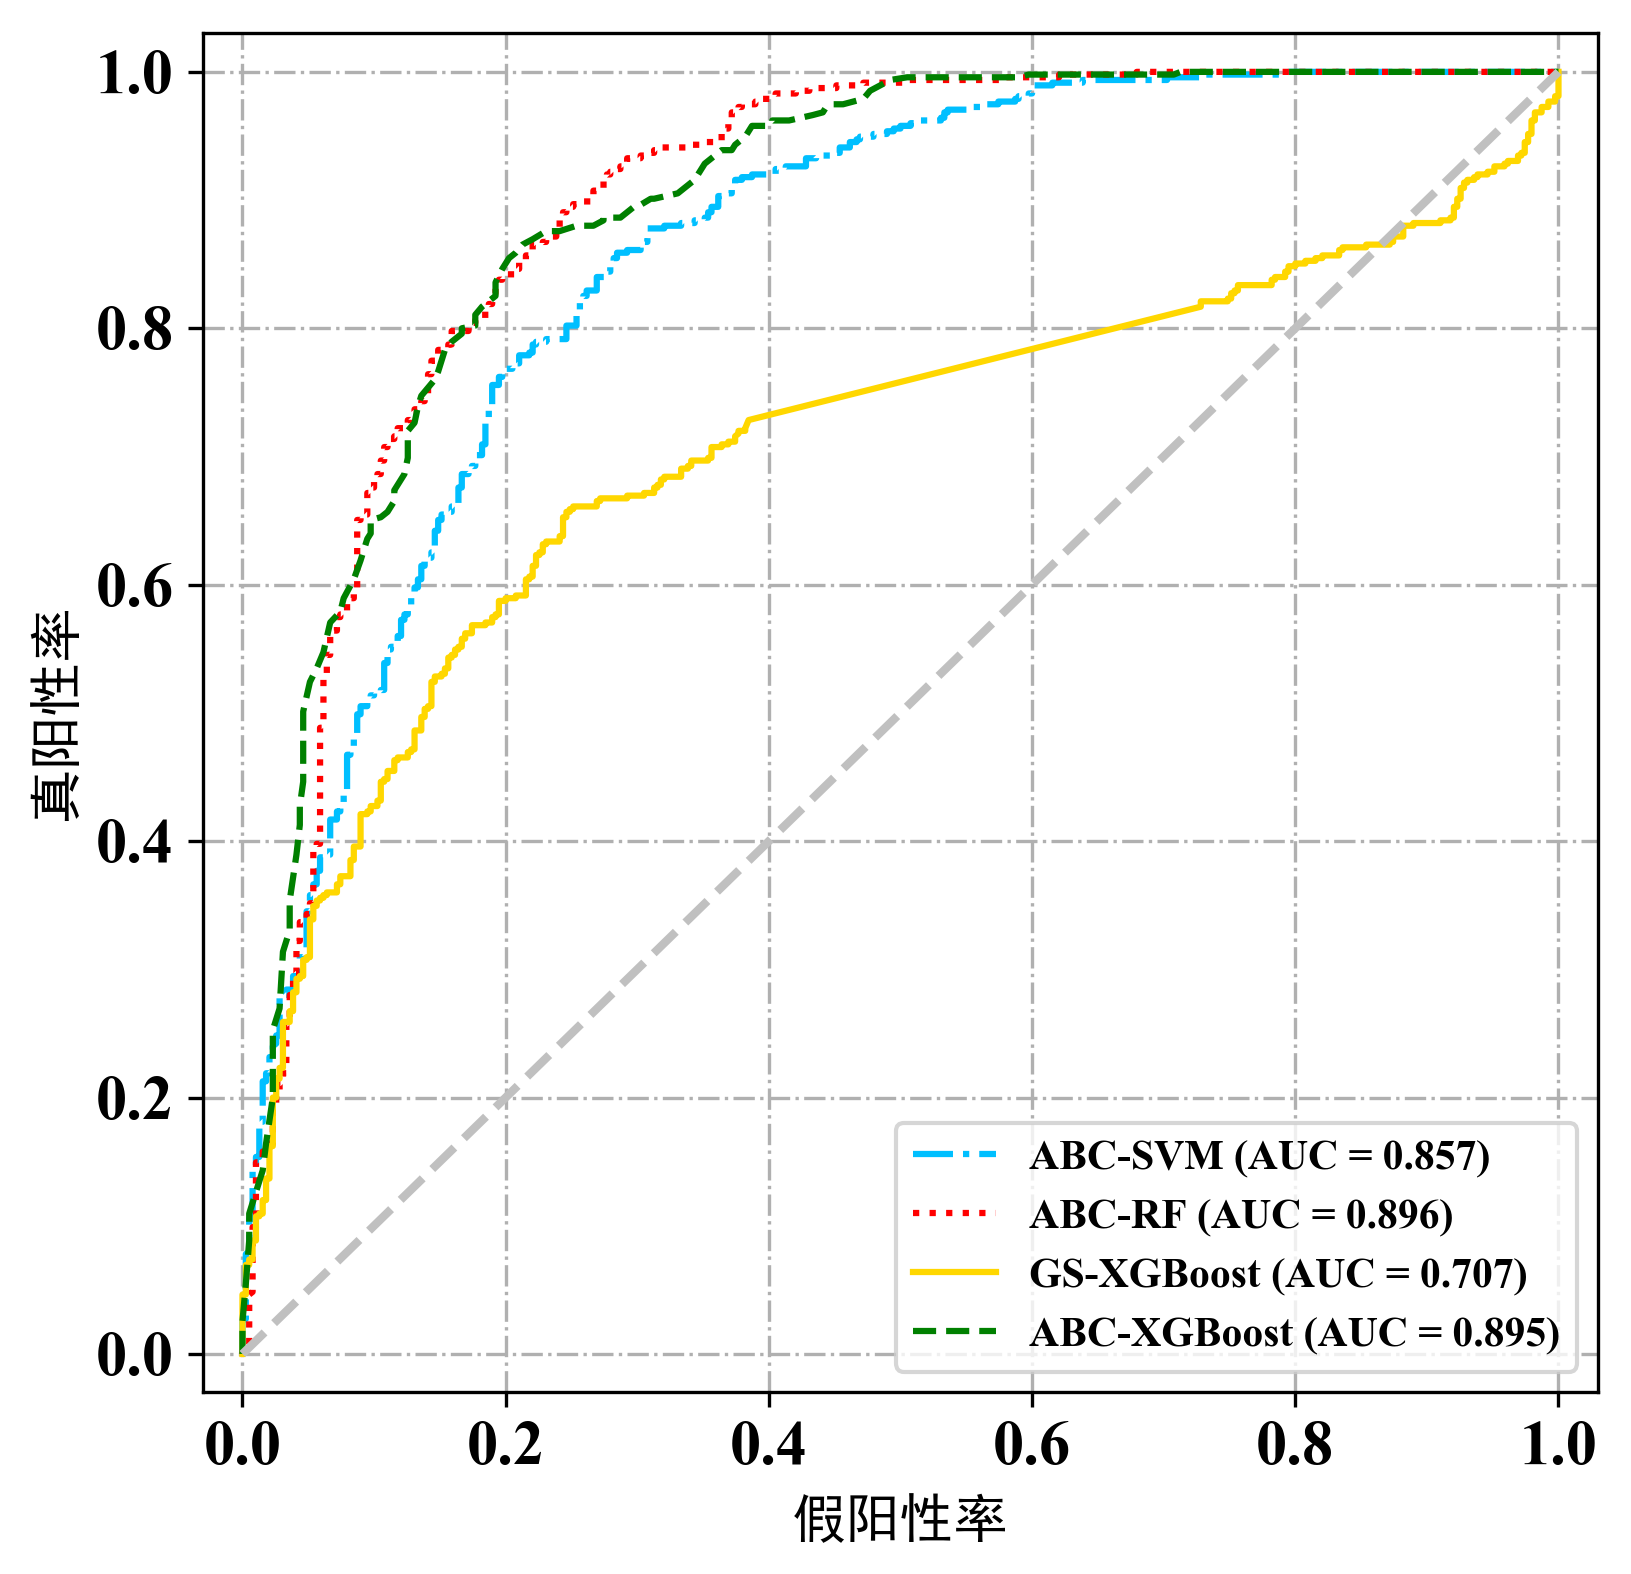

In [32]:
font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':18
}
mpl.rc("font", **font)

font2 = {
    'family':'SimHei',
    #'weight':'bold',
    'size':18
}
clf1 = ABC_svm_1
clf2 = ABC_rf_1
clf3 = GS_xgb_1
clf4 = ABC_xgb_1

test_prob1 = clf1.predict_proba(stage1_testX)[:,1]
test_prob2 = clf2.predict_proba(stage1_testX)[:,1]
test_prob3 = clf3.predict_proba(stage1_testX)[:,1]
test_prob4 = clf4.predict_proba(stage1_testX)[:,1]
fpr1, tpr1, thresholds = roc_curve(stage1_testY, test_prob1)
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, thresholds = roc_curve(stage1_testY, test_prob2)
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, thresholds = roc_curve(stage1_testY, test_prob3)
roc_auc3 = auc(fpr3, tpr3)
fpr4, tpr4, thresholds = roc_curve(stage1_testY, test_prob4)
roc_auc4 = auc(fpr4, tpr4)

plt.subplots(figsize=(6,6),dpi=300);
plt.plot(fpr1, tpr1, color='deepskyblue',lw=1.5, linestyle='-.',\
         label='ABC-SVM (AUC = %0.3f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red',lw=1.5, linestyle=':',label='ABC-RF (AUC = %0.3f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='gold',lw=1.5,linestyle='-',label='GS-XGBoost (AUC = %0.3f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='green',lw=1.5,linestyle='--' ,label='ABC-XGBoost (AUC = %0.3f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='silver', lw=2, linestyle='--');
plt.xlim([-0.03, 1.03]);
plt.ylim([-0.03, 1.03]);
plt.grid(linestyle='-.')
plt.xlabel('假阳性率',font2);
plt.ylabel('真阳性率',font2);
#plt.title('ROC Curve');
plt.legend(loc="lower right",fontsize=10);
plt.savefig('./输出图片/第一阶段ROC图.jpg')
# plt.show()

## 对所有井作预测，得到隔夹层剔除数据

In [19]:
chosen_curve = ['mm_GR','mm_SP','mm_RT','mm_AC','mm_SH']
curve_grad = ['GRgrad','SPgrad','RTgrad','ACgrad','SHgrad']
#输入取心井的测井数据
core_data = pd.read_csv('./整合后csv/单砂体岩心井数据.csv',encoding='utf-8')
#输入190口骨架井测井数据
_190_csv = pd.read_csv('./整合后csv/190口单砂体数据.csv',encoding='utf-8')
_190_data = _190_csv.fillna(0)

stage1_coreX = core_data[chosen_curve+curve_grad]
stage1_190X = _190_data[chosen_curve+curve_grad]
#将预测结论作为新列
answer1 = ABC_xgb_1.predict(stage1_coreX)
answer2 = GS_xgb_1.predict(stage1_coreX)
answer3 = ABC_svm_1.predict(stage1_coreX)
answer4 = ABC_rf_1.predict(stage1_coreX)

answer5 = ABC_xgb_1.predict(stage1_190X)
answer6 = GS_xgb_1.predict(stage1_190X)
answer7 = ABC_svm_1.predict(stage1_190X)
answer8 = ABC_rf_1.predict(stage1_190X)

core_data['ABC_xgb1'] = answer1
core_data['GS_xgb1'] = answer2
core_data['ABC_svm1'] = answer3
core_data['ABC_rf1'] = answer4

_190_data['ABC_xgb1'] = answer5
_190_data['GS_xgb1'] = answer6
_190_data['ABC_svm1'] = answer7
_190_data['ABC_rf1'] = answer8
#将各个结果存进表里，便于后续作图和使用
core_data.to_csv('./整合后csv/单砂体岩心井数据V2_0.csv',encoding='utf-8-sig',index=None)
_190_data.to_csv('./整合后csv/190口单砂体数据V2_0.csv',encoding='utf-8-sig',index=None)

## 做剔除隔夹层单井图

In [52]:
def show_stage1_single_well(data,wellname,save=False):
    X_to_draw=data[data['WELL_ID']==wellname].reset_index(drop=True)
    col1 = X_to_draw['ABC_svm1']
    col2 = medfilt(X_to_draw['ABC_rf1'],kernel_size=5)
    col3 = medfilt(X_to_draw['GS_xgb1'],kernel_size=5)
    col4 = medfilt(X_to_draw['ABC_xgb1'],kernel_size=5)
    font = {
        'family':'Times New Roman',
        #'weight':'bold',
        'size':13
    }
    font2 = {
        'family':'SimHei',
        #'weight':'bold',
        'size':13
    }
    mpl.rc("font", **font)
    #
    plt.rcParams['ytick.direction'] = 'in'
    cluster1 = np.repeat(np.expand_dims(col1,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(col2,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(col3,1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(col4,1), 100, 1)
    cluster5 = np.repeat(np.expand_dims(X_to_draw['CHUC'],1), 100, 1)
    
    layers_colors = ['white',#0 ---隔夹层
                     'gold',#1  ---单砂体
                    ]                             
    cmap_facies = colors.ListedColormap(
                layers_colors[0:len(layers_colors)], 'indexed')
    
    ztop=X_to_draw.DEPTH.min(); zbot=X_to_draw.DEPTH.max()
    # 创建画布
    f, ax = plt.subplots(nrows=1, ncols=10, figsize=(12, 12), dpi = 300)
    #fig = plt.figure(figsize = (16,12), dpi = dpi)
    #ax1 = plt.subplot(1,13,1)
    ax[0].plot(X_to_draw.GR, X_to_draw.DEPTH, color='deepskyblue')
    ax[0].set_xlabel("GR(API)")
    ax[0].grid(linestyle='-.')
    ax[0].set_ylim(ztop,zbot)
    ax[0].invert_yaxis()
    ax[0].set_ylabel('深度(m)',font2)
    
    ax[1].plot(X_to_draw.SP, X_to_draw.DEPTH,'-r')
    ax[1].set_xlim(X_to_draw.SP.min()-0.5,X_to_draw.SP.max()+0.5)
    ax[1].set_xlabel("SP(mV)")
    
    ax[2].plot(X_to_draw.RT, X_to_draw.DEPTH,'lime')
    ax[2].set_xlabel("RT(Ω·m)")
    
    ax[3].plot(X_to_draw.AC, X_to_draw.DEPTH,color='violet')
    ax[3].set_xlabel("AC(μs/m)")
        
    ax[4].imshow(cluster1,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[4].set_xlabel('ABC-SVM',rotation=25)
    
    ax[5].imshow(cluster2,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[5].set_xlabel('ABC-RF',rotation=25)
    
    ax[6].imshow(cluster3,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[6].set_xlabel('GS-XGBoost',rotation=25)
    
    ax[7].imshow(cluster4,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[7].set_xlabel('ABC-XGBoost',rotation=25)
    
    #论文中删掉了专家识别结论的说法，转而直接在岩心上标记
    im = ax[8].imshow(cluster5,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[8].set_xlabel('专家识别结论',font2,rotation=25)
    
    im = ax[9].plot(0,0,color='violet')
    ax[9].set_xlabel('岩心剖面',font2,rotation=25)
    
    #对前几列来说，统一网格线，顶底坐标
    for i in range(1,4):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid(linestyle='-.')
        yticks = ax[i].yaxis.get_major_ticks()
        for j in range(len(yticks)):
            yticks[j].label1.set_visible(False)
    
    for i in range(4,10):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    #plt.show()
    if save==True:
        plt.savefig('./输出图片/单井隔夹层剔除成果示意图.jpg')

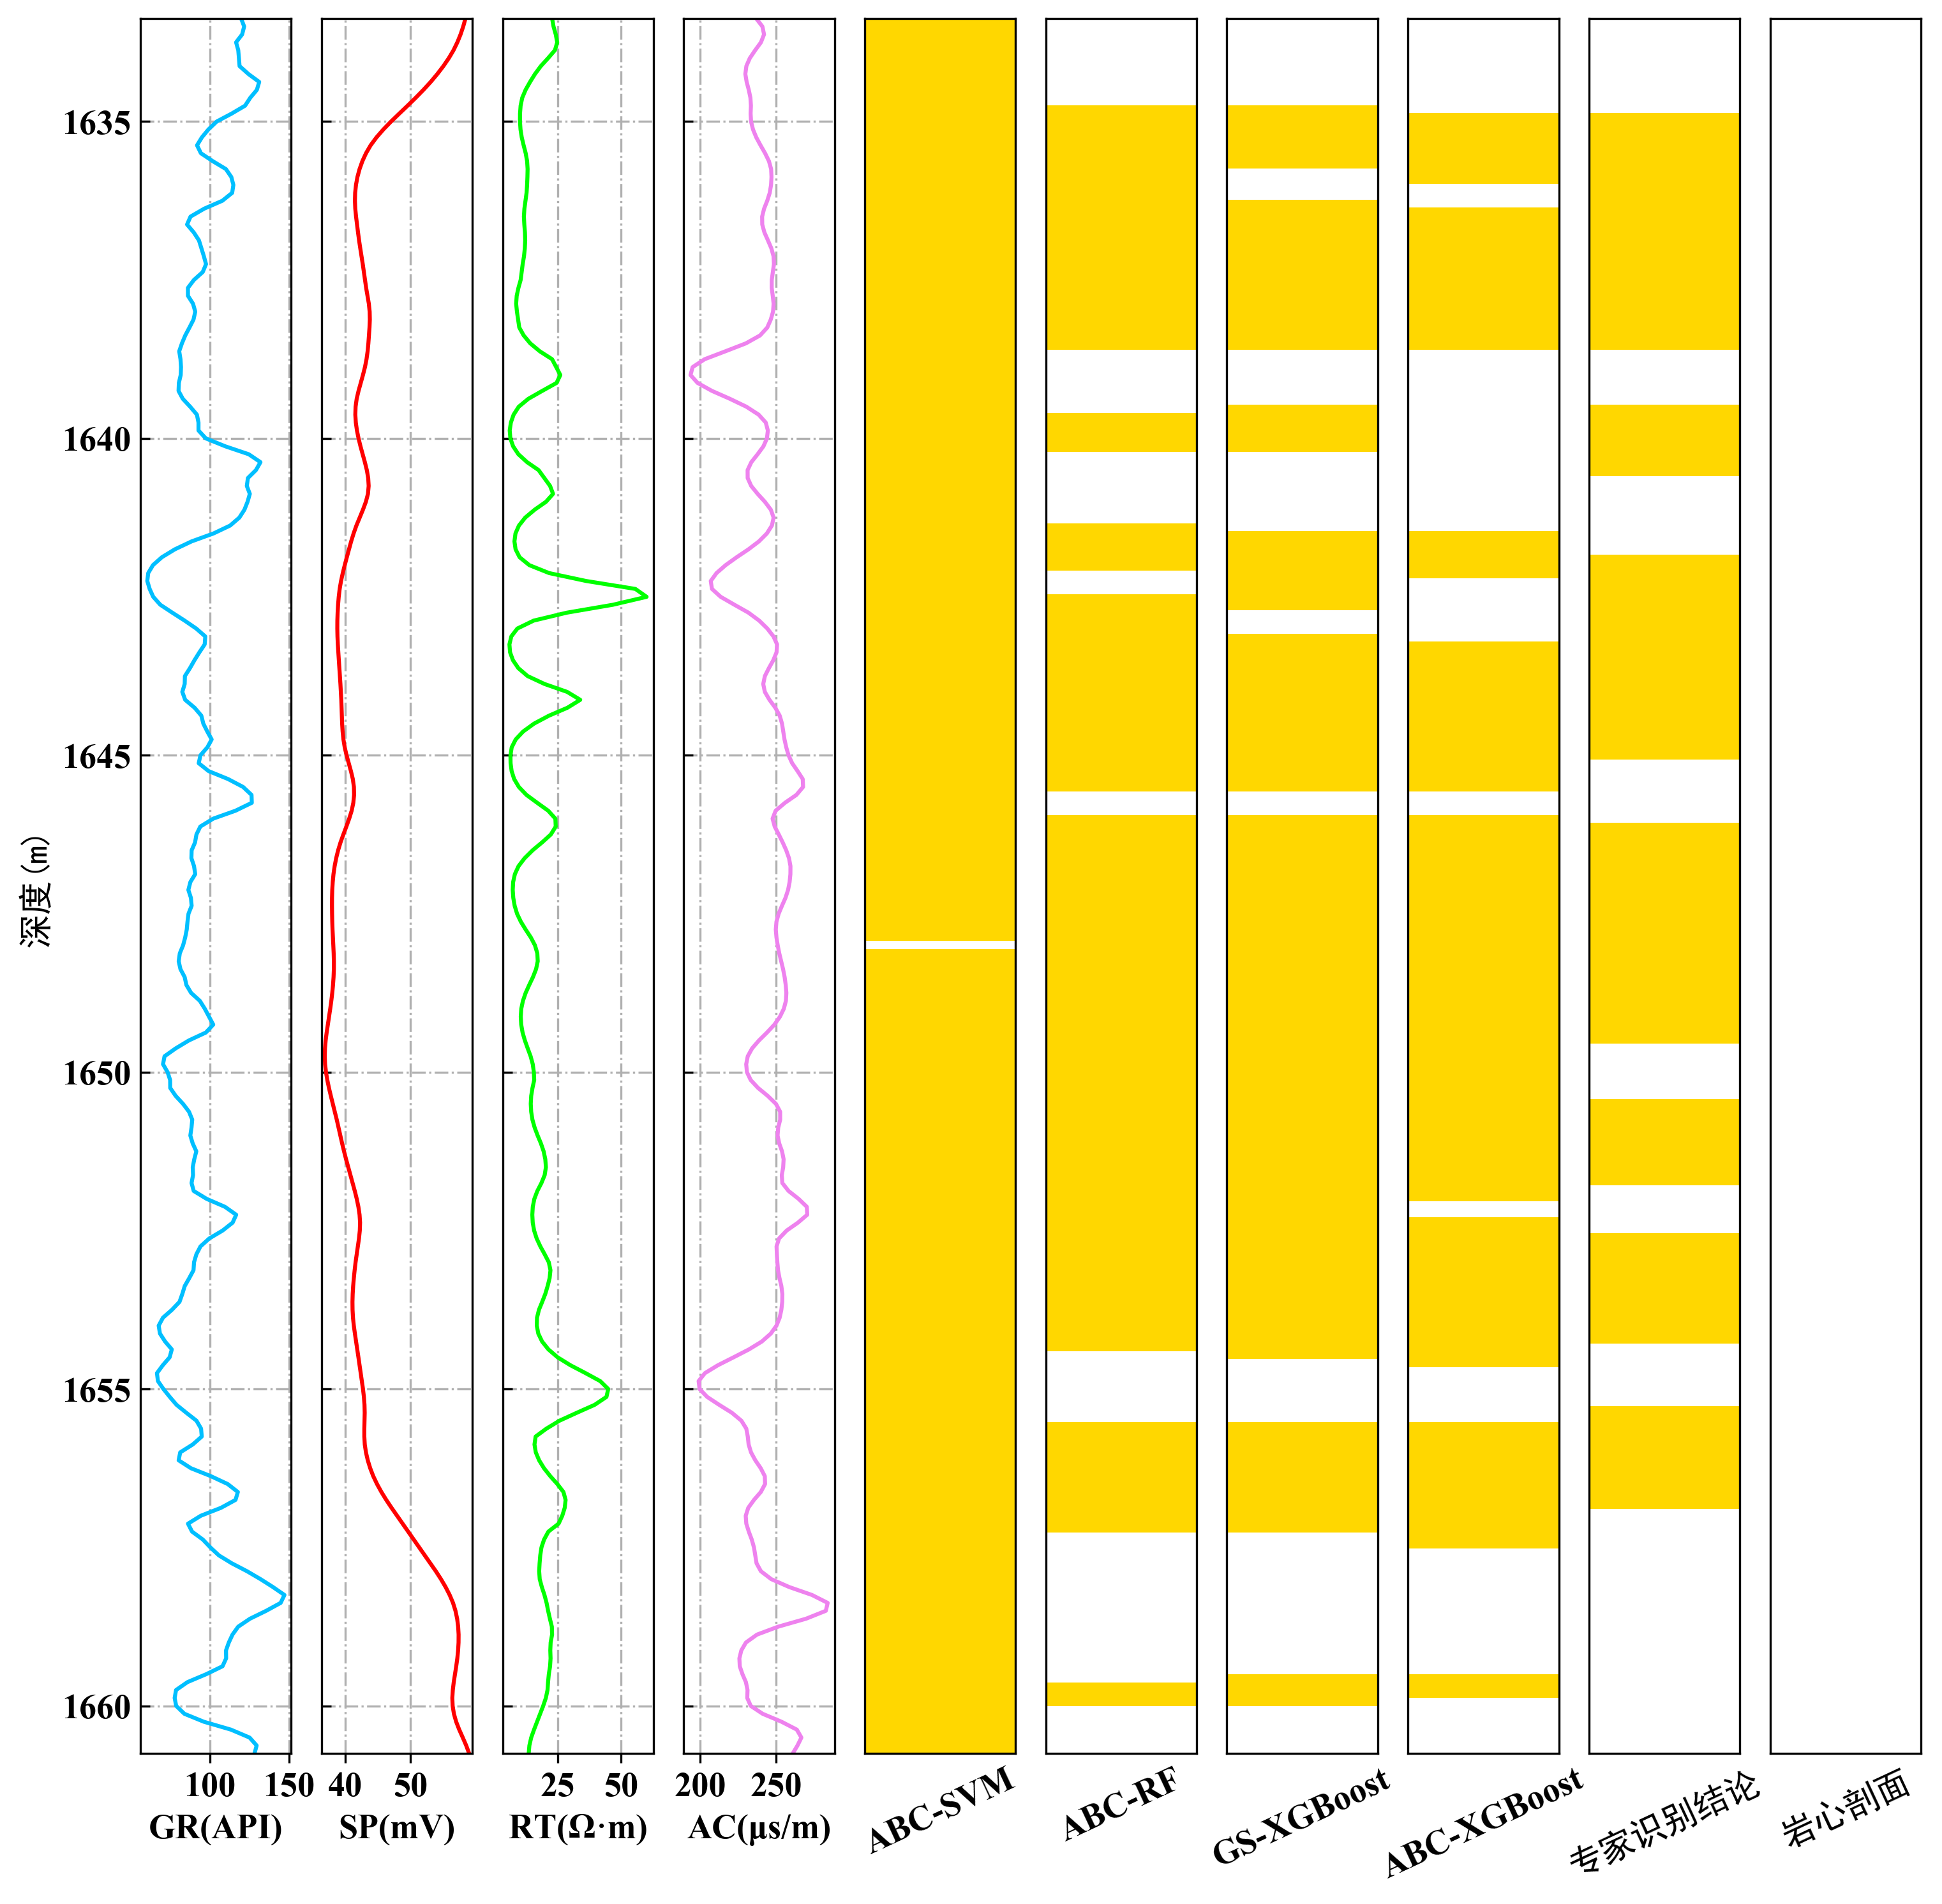

In [53]:
#以‘罗检36-361’为例展示单井成果
show_stage1_single_well(core_data,'罗检36-361',True)

# 阶段二：单砂体精细识别

## 选择输入数据规模

- 在第二阶段的单砂体识别过程中，仅采用24口井作为训练数据时，准确率在80%~85%左右
- 而选用190口井时，准确率能达到93%以上
- 在第一阶段选用的是24口岩心井，为了流程的连贯，选择24口井数据

In [85]:
#再导入一遍
_190_csv = pd.read_csv('./整合后csv/190口单砂体数据.csv',encoding='utf-8')
_190_csv = _190_csv.fillna(0)
_190_data = _190_csv[_190_csv['SSB']!=0].reset_index(drop=True)

core_data = pd.read_csv('./整合后csv/单砂体岩心井数据V2_0.csv',encoding='utf-8')


In [47]:
####################################################
##########第一种，选择24口岩心井作为数据集###############
####################################################
#指定训练井和测试井
train_names = ['ZJ65','DP10','罗37-23','罗40-31','罗检34-281','罗34-31','罗37-36','罗检34-364',
              '罗41-37','罗33-371','罗加36-384','DP3','罗37-42','罗24-32','罗28-39','罗加32-44','罗28-47',
              '罗22-44','ZJ47','镰125']
test_names = ['罗635-29','罗31-34','罗检36-361','罗检38-365']

train_data_dst = core_data[core_data['WELL_ID'].isin(train_names)].reset_index(drop=True)
test_data_dst = core_data[core_data['WELL_ID'].isin(test_names)].reset_index(drop=True)

In [86]:
####################################################
############第二种，选择190口井作为数据集###############
####################################################
#随机选择训练井和测试井，第一种是所有井，以20%和80%分割
random.seed(0)
all_well = list(_190_data.WELL_ID.unique())
all_well_num = len(all_well)
random.shuffle(all_well)
cut = int(all_well_num*0.8)
train_names = all_well[:cut]
test_names = all_well[cut:]
#把罗检36-361换到测试集中用于展示
train_names.remove('罗检36-361')
test_names.append('罗检36-361')
train_data_dst = _190_data[_190_data['WELL_ID'].isin(train_names)].reset_index(drop=True)
test_data_dst = _190_data[_190_data['WELL_ID'].isin(test_names)].reset_index(drop=True)

这个过程和上面一致，只是输入变了，stage1换成stage2

In [48]:
#所有曲线作为输入，并把‘隔夹层为0，单砂体为1’的‘CHUC’列加入其中
stage2_trainX = train_data_dst[['mm_DEPTH','mm_GR','mm_SP','mm_RT','mm_AC','mm_POR','mm_PERM','mm_SW','CHUC']]
stage2_trainY = train_data_dst.SSB.values
stage2_testX = test_data_dst[['mm_DEPTH','mm_GR','mm_SP','mm_RT','mm_AC','mm_POR','mm_PERM','mm_SW','CHUC']]
stage2_testY = test_data_dst.SSB.values

## 特征重要性筛选

[16:41:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




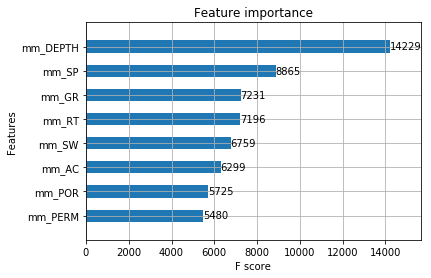

In [98]:
impo_X = train_data_dst[['mm_GR','mm_SP','mm_RT','mm_AC','mm_POR','mm_PERM','mm_SW','mm_DEPTH']]
impo_Y = train_data_dst.SSB.values
xgb_ori = XGBClassifier(learning_rate = 0.001, n_estimators=500, max_depth=6,
                          min_child_weight=5, gamma=0.5, subsample=0.8,
                          colsample_bytree=0.8, objective='multi:softprob',
                          nthread=4, scale_pos_weight=1, seed=27)
xgb_ori.fit(impo_X,impo_Y)
xgb.plot_importance(xgb_ori,height=0.5)
plt.show()

- 这个特征重要性仅供参考
- 或许有更好的特征筛选方式
- 做着一步的用意是为了增加特征筛选环节，使得分两阶段实验有所差别，在逻辑上更合理

## 建立模型并训练

### ABC-XGBoost

In [100]:
def run_abc_xgboost(lowBounds,upBounds,optimizer):
    #下限和上限都用列表
    model = Hive.BeeHive(lower = lowBounds, 
                         upper = upBounds ,  
                         fun       = optimizer,
                         numb_bees =  200       ,
                         max_itrs  =  2       ,)

    # runs model
    cost,sol = model.run()

    return cost,sol

#后3个不重要的参数直接赋值了，调参太费时间
#如果想完全调参，也可以自行修改
def optimizer_xgb(params):
    #交叉验证的部分未做
    xgb = XGBClassifier(learning_rate =10 ** params[0],n_estimators = int(params[1]),
                         max_depth=int(params[2]),min_child_weight=params[3],
                         gamma=0.1,subsample=0.8,colcample_bytree=0.8).fit(stage2_trainX, stage2_trainY)

    pred_proba = xgb.predict_proba(stage2_trainX)
    return log_loss(stage2_trainY,pred_proba)
    
#调参的范围
#learning_rate [0.001,1]
#n_estimators  [100,500]
#max_depth  [3,10]
#min_child_weight  [0,10]
#gamma  [0,1]
#subsample  [0,1]
#colcample_bytree  [0,1]
cost_xgb,sol = run_abc_xgboost([-3,100,3,0],[0,500,10,10],optimizer_xgb)

#使用最优参数获得最优化模型
ABC_xgb_2 = XGBClassifier(learning_rate =10 ** sol[0],n_estimators = int(sol[1]),
                         max_depth=int(sol[2]),min_child_weight=sol[3],
                         gamma=0.1,subsample=0.8,colcample_bytree=0.8).fit(stage2_trainX, stage2_trainY)

[16:52:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:53:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:53:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[16:54:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:54:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:54:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[16:55:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:56:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:56:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[16:57:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:57:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:57:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[16:58:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:58:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:58:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:00:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:00:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:00:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:01:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:01:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:01:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:03:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:04:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:04:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:04:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:05:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:07:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:08:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:10:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:13:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:13:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:17:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:19:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:21:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:21:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:21:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:23:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:23:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:23:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:24:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:24:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:24:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:26:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:26:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:26:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:29:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:29:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

[17:32:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:32:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:32:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colcample_bytree } might not be used.

  This may not be accurate due to some parameters are onl

混淆矩阵的作图程序在第6章程序中，此处不再赘述

In [113]:
pred = ABC_xgb_2.predict(stage2_testX)
cm1 = confusion_matrix(stage2_testY,pred)
cm2 = classification_report(stage2_testY,pred,digits=3)
print(cm1)
print('='*100)
print(cm2)
#保存模型
save_model(ABC_xgb_2,'ABC_xgb_2')


[17:53:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[[ 33  13   0   0   0   0   0]
 [  1  40  42   0   0   0   0]
 [  0   1  77  29   0   0   0]
 [  0   0  10  83  31   0   0]
 [  0   0   0   4  69   9   0]
 [  0   0   0   0   7  26   0]
 [  0   0   0   0   0   0 390]]
              precision    recall  f1-score   support

           1      0.971     0.717     0.825        46
           2      0.741     0.482     0.584        83
           3      0.597     0.720     0.653       107
           4      0.716     0.669     0.692       124
           5      0.645     0.841     0.730        82
           6      0.743     0.788     0.765        33
         

### GS-XGBoost

In [108]:
GS_xgb_2 = XGBClassifier(learning_rate = 0.001, n_estimators=500, max_depth=6,
                          min_child_weight=5, gamma=0.1, subsample=0.8,
                          colsample_bytree=0.8, objective='binary:logistic',
                          nthread=4, scale_pos_weight=1, seed=27).fit(stage2_trainX, stage2_trainY)
#展示结果
pred = GS_xgb_2.predict(stage2_testX)
cm1 = confusion_matrix(stage2_testY,pred)
cm2 = classification_report(stage2_testY,pred,digits=3)
print(cm1)
print('='*100)
print(cm2)
# 保存模型
save_model(GS_xgb_2,'GS_xgb_2')

Save Done

[[ 33  13   0   0   0   0   0]
 [  5  39  39   0   0   0   0]
 [  0   0  77  30   0   0   0]
 [  0   0  11  75  38   0   0]
 [  0   0   0   4  65  13   0]
 [  0   0   0   0   5  28   0]
 [  0   0   0   0   0   0 390]]
              precision    recall  f1-score   support

           1      0.868     0.717     0.786        46
           2      0.750     0.470     0.578        83
           3      0.606     0.720     0.658       107
           4      0.688     0.605     0.644       124
           5      0.602     0.793     0.684        82
           6      0.683     0.848     0.757        33
           7      1.000     1.000     1.000       390

   micro avg      0.817     0.817     0.817       865
   macro avg      0.743     0.736     0.729       865
weighted avg      0.826     0.817     0.816       865



### ABC-SVM

In [115]:
def run_abc_svm(lowBounds,upBounds,optimizer):

    model = Hive.BeeHive(lower = lowBounds, # MUST BE A LIST !
                         upper = upBounds , # MUST BE A LIST ! 
                         fun       = optimizer ,
                         numb_bees =  200,
                         max_itrs  =  2)

    # runs model
    cost,sol = model.run()
    return cost,sol

def optimizer_svm(params):

    SVM = svm.SVC(C=10 ** params[0], gamma=10 ** params[1],probability=True).fit(stage2_trainX, stage2_trainY)
    
    pred_proba = SVM.predict_proba(stage2_trainX)
    return log_loss(stage2_trainY,pred_proba)

# 惩罚因子C [0.1,100]
# 核函数平滑因子γ [0.1,10]
cost_svm,sol= run_abc_svm([-1,-1],[2,1],optimizer_svm)

EVALS:422


In [118]:
ABC_svm_2 = svm.SVC(C=10 ** sol[0], gamma=10 ** sol[1],probability=True).fit(stage2_trainX, stage2_trainY)
pred = ABC_svm_2.predict(stage2_testX)
cm1 = confusion_matrix(stage2_testY,pred)
cm2 = classification_report(stage2_testY,pred,digits=3)
print(cm1)
print('='*100)
print(cm2)
# 保存模型
save_model(ABC_svm_2,'ABC_svm_2')

[[ 20  15   5   0   0   0   6]
 [ 15  20  39   0   0   0   9]
 [  2   0  66  29   0   0  10]
 [  0   0   9  59  23   6  27]
 [  0   0   0  10  66   6   0]
 [  0   0   0   1  24   8   0]
 [  0   0   0   0   0   0 390]]
              precision    recall  f1-score   support

           1      0.541     0.435     0.482        46
           2      0.571     0.241     0.339        83
           3      0.555     0.617     0.584       107
           4      0.596     0.476     0.529       124
           5      0.584     0.805     0.677        82
           6      0.400     0.242     0.302        33
           7      0.882     1.000     0.938       390

   micro avg      0.727     0.727     0.727       865
   macro avg      0.590     0.545     0.550       865
weighted avg      0.706     0.727     0.705       865

Save Done



### ABC-RF

In [119]:
def run_abc_rf(lowBounds,upBounds,optimizer):

    model = Hive.BeeHive(lower = lowBounds, # MUST BE A LIST !
                         upper = upBounds , # MUST BE A LIST ! 
                         fun       = optimizer ,
                         numb_bees =  200       ,
                         max_itrs  =  2       ,)
    # runs model
    cost,sol = model.run()

    return cost,sol

def optimizer_rf(params):

    rf = RandomForestClassifier(max_depth=params[0],min_weight_fraction_leaf=params[1],
                                  n_estimators = int(params[2])).fit(stage2_trainX, stage2_trainY)
    pred_proba = rf.predict_proba(stage2_trainX)
    return log_loss(stage2_trainY,pred_proba)
    

cost_rf,sol = run_abc_rf([3,0,10],[100,0.5,200],optimizer_rf)
ABC_rf_2 = RandomForestClassifier(max_depth=sol[0],min_weight_fraction_leaf=sol[1],
                                  n_estimators = int(sol[2])).fit(stage2_trainX, stage2_trainY)

EVALS:482


In [120]:
#展示结果
pred = ABC_rf_2.predict(stage2_testX)
cm1 = confusion_matrix(stage2_testY,pred)
cm2 = classification_report(stage2_testY,pred,digits=3)
print(cm1)
print('='*100)
print(cm2)
# 保存模型
save_model(ABC_rf_2,'ABC_rf_2')

[[ 30  15   1   0   0   0   0]
 [  1  51  31   0   0   0   0]
 [  0   2  81  21   3   0   0]
 [  0   0  13  73  38   0   0]
 [  0   0   0   2  77   3   0]
 [  0   0   0   0  29   4   0]
 [  0   0   0   0   0   0 390]]
              precision    recall  f1-score   support

           1      0.968     0.652     0.779        46
           2      0.750     0.614     0.675        83
           3      0.643     0.757     0.695       107
           4      0.760     0.589     0.664       124
           5      0.524     0.939     0.672        82
           6      0.571     0.121     0.200        33
           7      1.000     1.000     1.000       390

   micro avg      0.816     0.816     0.816       865
   macro avg      0.745     0.668     0.669       865
weighted avg      0.834     0.816     0.810       865

Save Done



## 适应度图STAGE2

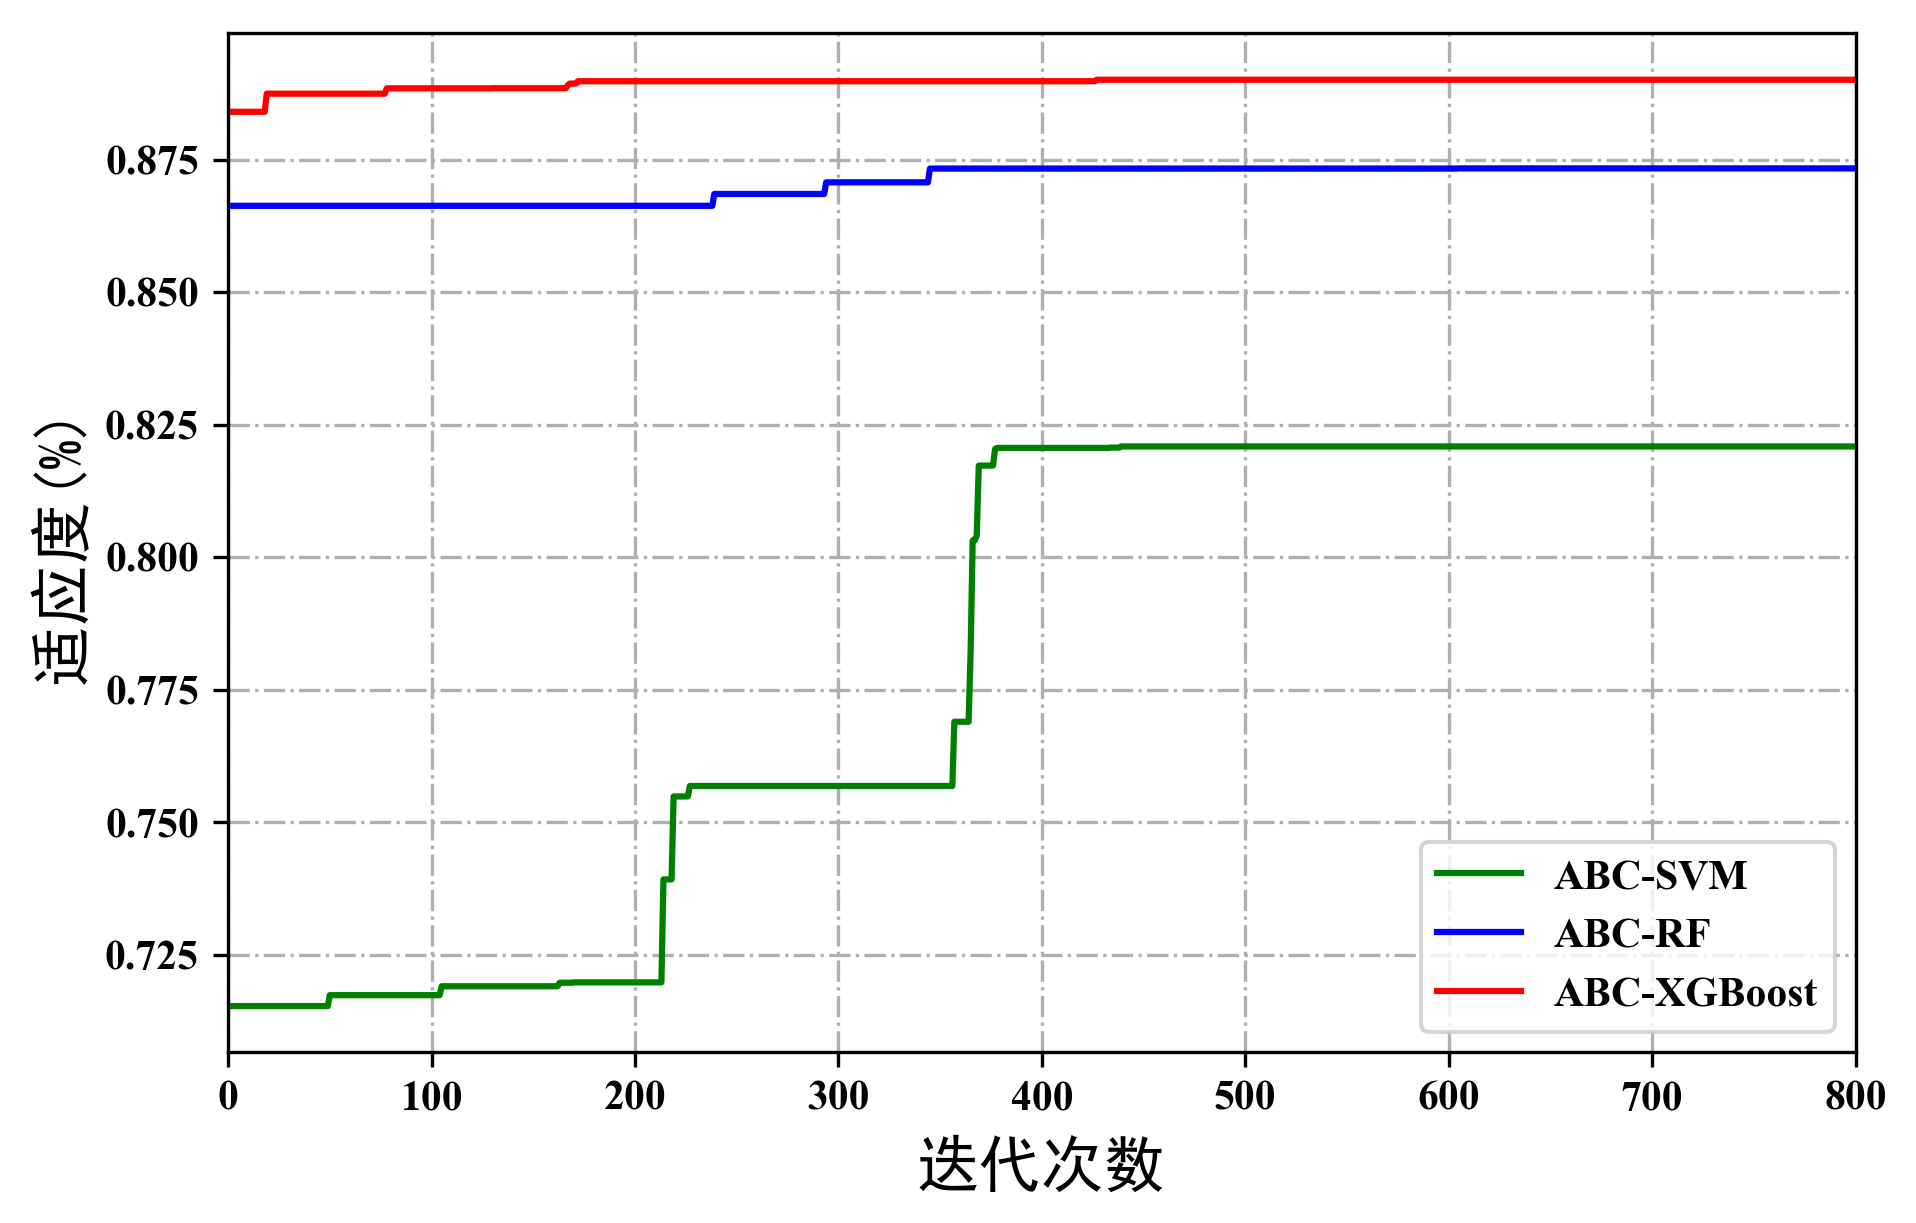

In [133]:
# FITNESS = pd.DataFrame([cost_xgb['best'],cost_svm['best'],cost_rf['best']]).T
# FITNESS.columns = ['XGB','SVM','RF']
#保存一下，如果之后有改动可以从这里重新作图
# FITNESS.to_csv("./输入csv/FITNESS_S2.csv",encoding='utf-8-sig',index=None)
#这里我是引用的我之前跑的程序结果
FITNESS = pd.read_csv('./输入csv/FITNESS_S2.csv',encoding='utf-8')
font = {
    'family':'Times New Roman',
    #'weight':'bold',
    'size':15
}
font2 = {
    'family':'SimHei',
    #'weight':'bold',
    'size':15
}
mpl.rc("font", **font)
labels = ['ABC-SVM',"ABC-RF","ABC-XGBoost" ]
plt.figure(figsize=(7, 4.5),dpi=300);
#plt.plot(range(len(cost["best"])), [i-0.01 for i in cost['best']],color='red', label=labels[0])
plt.plot(range(len(FITNESS['SVM'])), 1/(1+FITNESS['SVM']),color='g' ,label=labels[0]);
plt.plot(range(len(FITNESS['RF'])), 1/(1+FITNESS['RF']),color='blue', label=labels[1]);
plt.plot(range(len(FITNESS['XGB'])), 1/(1+FITNESS['XGB']),color='red', label=labels[2])

plt.xlim([0,800]);
# plt.yticks([0.305, 0.310, 0.315,0.320, 0.325,0.330],
#   [0.28, 0.29, 0.30, 0.31, 0.32,0.33])
# plt.xticks([0, 200, 400, 600, 800],
#   [0, 100, 200, 300, 400])

plt.xlabel("迭代次数",font2);
plt.ylabel("适应度(%)",font2);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="best",fontsize=10);

plt.grid(linestyle='-.');
# plt.savefig('./输出图片/适应度函数图.jpg')
# plt.show()

## 重载模型

In [45]:
ABC_xgb_2 = load_model('ABC_xgb_2')
GS_xgb_2 = load_model('GS_xgb_2')
ABC_svm_2 = load_model('ABC_svm_2')
ABC_rf_2 = load_model('ABC_rf_2')

## 混淆矩阵作图

In [54]:
pred = ABC_xgb_2.predict(stage2_testX)
cm = confusion_matrix(stage2_testY,pred)

Text(85.08333333333333, 0.5, '实际类别')

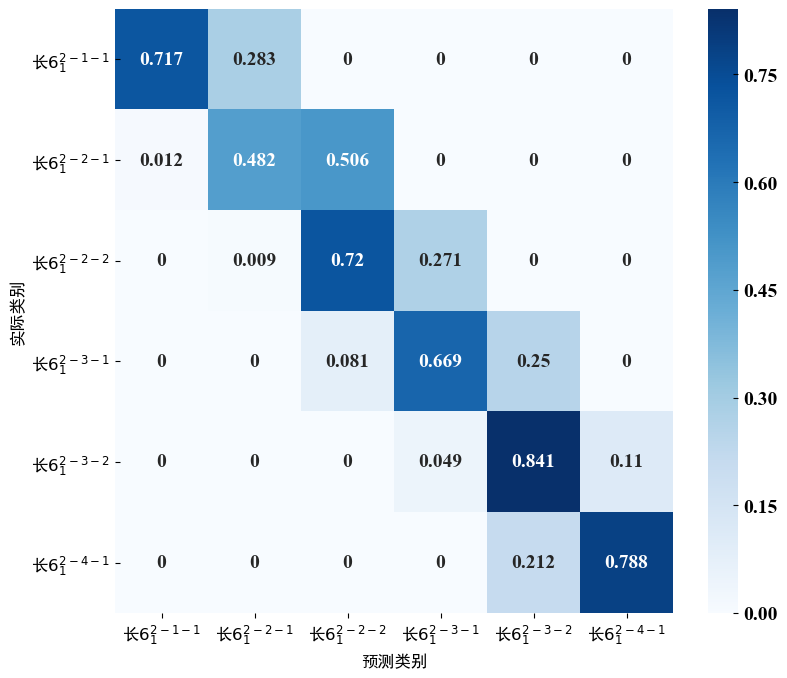

In [56]:
#中文字体黑体
font2 = {
    'family':'SimHei',
    #'weight':'bold',
#     'fontstyle':'italic',
    'size':15
}

#数字字体新罗马
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}
matplotlib.rc("font", **font)

con_mat = cm[:6,0:6]
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=3)

# === plot ===
figure = plt.figure(figsize=(9, 8),dpi=100)
#以heatmap热力图的方式呈现混淆矩阵
ax = sns.heatmap(con_mat_norm, annot=True,fmt='.3g',cmap='Blues')
#设置横纵坐标对应的刻度显示
ax.set_xticklabels([r'长'+r'$6_1^{2-1-1}$',
                    r'长'+r'$6_1^{2-2-1}$',
                    r'长'+r'$6_1^{2-2-2}$',
                    r'长'+r'$6_1^{2-3-1}$',
                    r'长'+r'$6_1^{2-3-2}$',
                    r'长'+r'$6_1^{2-4-1}$',],font2)
ax.set_yticklabels([r'长'+r'$6_1^{2-1-1}$',
                    r'长'+r'$6_1^{2-2-1}$',
                    r'长'+r'$6_1^{2-2-2}$',
                    r'长'+r'$6_1^{2-3-1}$',
                    r'长'+r'$6_1^{2-3-2}$',
                    r'长'+r'$6_1^{2-4-1}$',],font2,rotation=360)

plt.ylim(6, 0)
plt.xlim(0, 6)
plt.xlabel('预测类别',font2)
plt.ylabel('实际类别',font2)
# plt.savefig('./输出图片/混淆矩阵示例.jpg')

# 应用

## 应用于单井单砂体识别

- 以罗检36-361为例
- 所有算法直接沿用第一阶段分出来的储层类别

In [149]:
app_data = core_data[core_data['WELL_ID']=='罗检36-361']
STAGE2_CURVE =['mm_DEPTH','mm_GR','mm_SP','mm_RT','mm_AC','mm_POR','mm_PERM','mm_SW']
app_data['CHUC'] = app_data['ABC_xgb1']
app_abcxgb_x = app_data[STAGE2_CURVE+['CHUC']]
app_data['CHUC'] = app_data['GS_xgb1']
app_gsxgb_x = app_data[STAGE2_CURVE+['CHUC']]
app_data['CHUC'] = app_data['ABC_svm1']
app_svm_x = app_data[STAGE2_CURVE+['CHUC']]
app_data['CHUC'] = app_data['ABC_rf1']
app_rf_x = app_data[STAGE2_CURVE+['CHUC']]
app_Y = app_data.SSB.values

In [154]:
answer1 = medfilt(ABC_xgb_2.predict(app_abcxgb_x),kernel_size=5)
answer2 = medfilt(GS_xgb_2.predict(app_gsxgb_x),kernel_size=5)
answer3 = medfilt(ABC_svm_2.predict(app_svm_x),kernel_size=5)
answer4 = medfilt(ABC_rf_2.predict(app_rf_x),kernel_size=5)

app_data['ABC_xgb2'] = answer1
app_data['GS_xgb2'] = answer2
app_data['ABC_svm2'] = answer3
app_data['ABC_rf2'] = answer4

In [6]:
# app_data.to_csv('./整合后csv/LJ36-361应用.csv',encoding='utf-8-sig',index=None)
app_data = pd.read_csv('./整合后csv/LJ36-361应用.csv',encoding='utf-8')

In [12]:
def show_stage2_single_well(app_data,save=False):

    dst_y = app_data.SSB.values
    
    abc_xgb_score = app_data['ABC_xgb2']
    xgb_score = app_data['GS_xgb2']
    svm_score = app_data['ABC_svm2']
    rf_score = app_data['ABC_rf2']
    
    X_to_draw=app_data
    font = {
        'family':'Times New Roman',
        #'weight':'bold',
        'size':15
    }
    font2 = {
        'family':'SimHei',
        #'weight':'bold',
        'size':15
    }
    mpl.rc("font", **font)
    #
    plt.rcParams['ytick.direction'] = 'in'
    
    cluster1 = np.repeat(np.expand_dims(medfilt(svm_score,3),1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(rf_score,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(xgb_score,1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(abc_xgb_score,1), 100, 1)
    cluster5 = np.repeat(np.expand_dims(dst_y,1), 100, 1)
    
    layers_colors = [
                     'RED',#1  ---单砂体
                     'orange',#2  ---单砂体
                     'YELLOW',#3  ---单砂体
                     'lime',#4  ---单砂体
                     'cyan',#5  ---单砂体
                     'deepskyblue',#6  ---单砂体
                     'white',#7 ---隔夹层
                    ]                             
    cmap_facies = colors.ListedColormap(
                layers_colors[0:len(layers_colors)], 'indexed')
    
    #画岩性柱的颜色
    layers_colors_cols = ['deepskyblue',#6 ---隔夹层
                         'cyan',#5  ---单砂体
                         'lime',#4  ---单砂体
                         'YELLOW',#3  ---单砂体
                         'orange',#2  ---单砂体
                         'RED',#1  ---单砂体
                         'white',#7  ---单砂体
                                         ]                             
    cmap_facies_cols = colors.ListedColormap(
                layers_colors_cols[0:len(layers_colors_cols)], 'indexed')
    
    ztop=X_to_draw.DEPTH.min(); zbot=X_to_draw.DEPTH.max()
    # 创建画布
    f, ax = plt.subplots(nrows=1, ncols=10, figsize=(12, 12), dpi = 300)
    ax[0].plot(X_to_draw.GR, X_to_draw.DEPTH-ztop, color='deepskyblue')
    ax[0].set_xlabel("GR(API)")
    ax[0].grid(linestyle='-.')
    ax[0].set_ylim(ztop-ztop,zbot-ztop)
    ax[0].invert_yaxis()
    ax[0].set_ylabel('相对深度(m)',font2)
    ax[0].set_xlim(X_to_draw.GR.min()-5,X_to_draw.GR.max()-15)
    
    ax[1].plot(X_to_draw.POR, X_to_draw.DEPTH,color='deepskyblue',linestyle='--')
    ax[1].set_xlim(0,X_to_draw.POR.max()+5)
    ax[1].set_xlabel("POR(%)")
    
    ax[2].plot(X_to_draw.AC, X_to_draw.DEPTH,color='violet')
    ax[2].set_xlabel("AC(μs/m)")
    
    ax[3].plot(X_to_draw.RT, X_to_draw.DEPTH,'lime')
    ax[3].set_xlabel("RT(Ω·m)")
    
    ax[4].imshow(cluster1,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[4].set_xlabel('ABC-SVM',rotation=25)
    
    ax[5].imshow(cluster2,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[5].set_xlabel('ABC-RF',rotation=25)
    
    ax[6].imshow(cluster3,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[6].set_xlabel('GS-XGBoost',rotation=25)
    
    ax[7].imshow(cluster4,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[7].set_xlabel('ABC-XGBoost',rotation=25)
    
    im1 = ax[8].imshow(cluster5,interpolation='none', aspect='auto',
                          cmap=cmap_facies_cols)
    
    im2 = ax[8].imshow(cluster5,interpolation='none', aspect='auto',
                          cmap=cmap_facies)
    ax[8].set_xlabel('专家识别结论',font2,rotation=25)
    
    #岩心剖面置空
    ax[9].plot(0,0,color='violet')
    ax[9].set_xlabel('岩心剖面',font2,rotation=25)
    divider = make_axes_locatable(ax[9])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im1, cax=cax)
    cbar.set_label((5*' ').join(['长'+r'$6_1^{2-4-1}$','长'+r'$6_1^{2-3-2}$', 
                                 '长'+r'$6_1^{2-3-1}$','长'+r'$6_1^{2-2-2}$',
                                   '长'+r'$6_1^{2-2-1}$','长'+r'$6_1^{2-1-1}$', 
                                          '隔夹层',]),fontdict=font2)
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    #对前几列来说，统一网格线，顶底坐标
    for i in range(1,4):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid(linestyle='-.')
        yticks = ax[i].yaxis.get_major_ticks()
        for j in range(len(yticks)):
            yticks[j].label1.set_visible(False)
    
    for i in range(4,10):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    if save == True:
        plt.savefig('./输出图片/单井单砂体示例.jpg')       

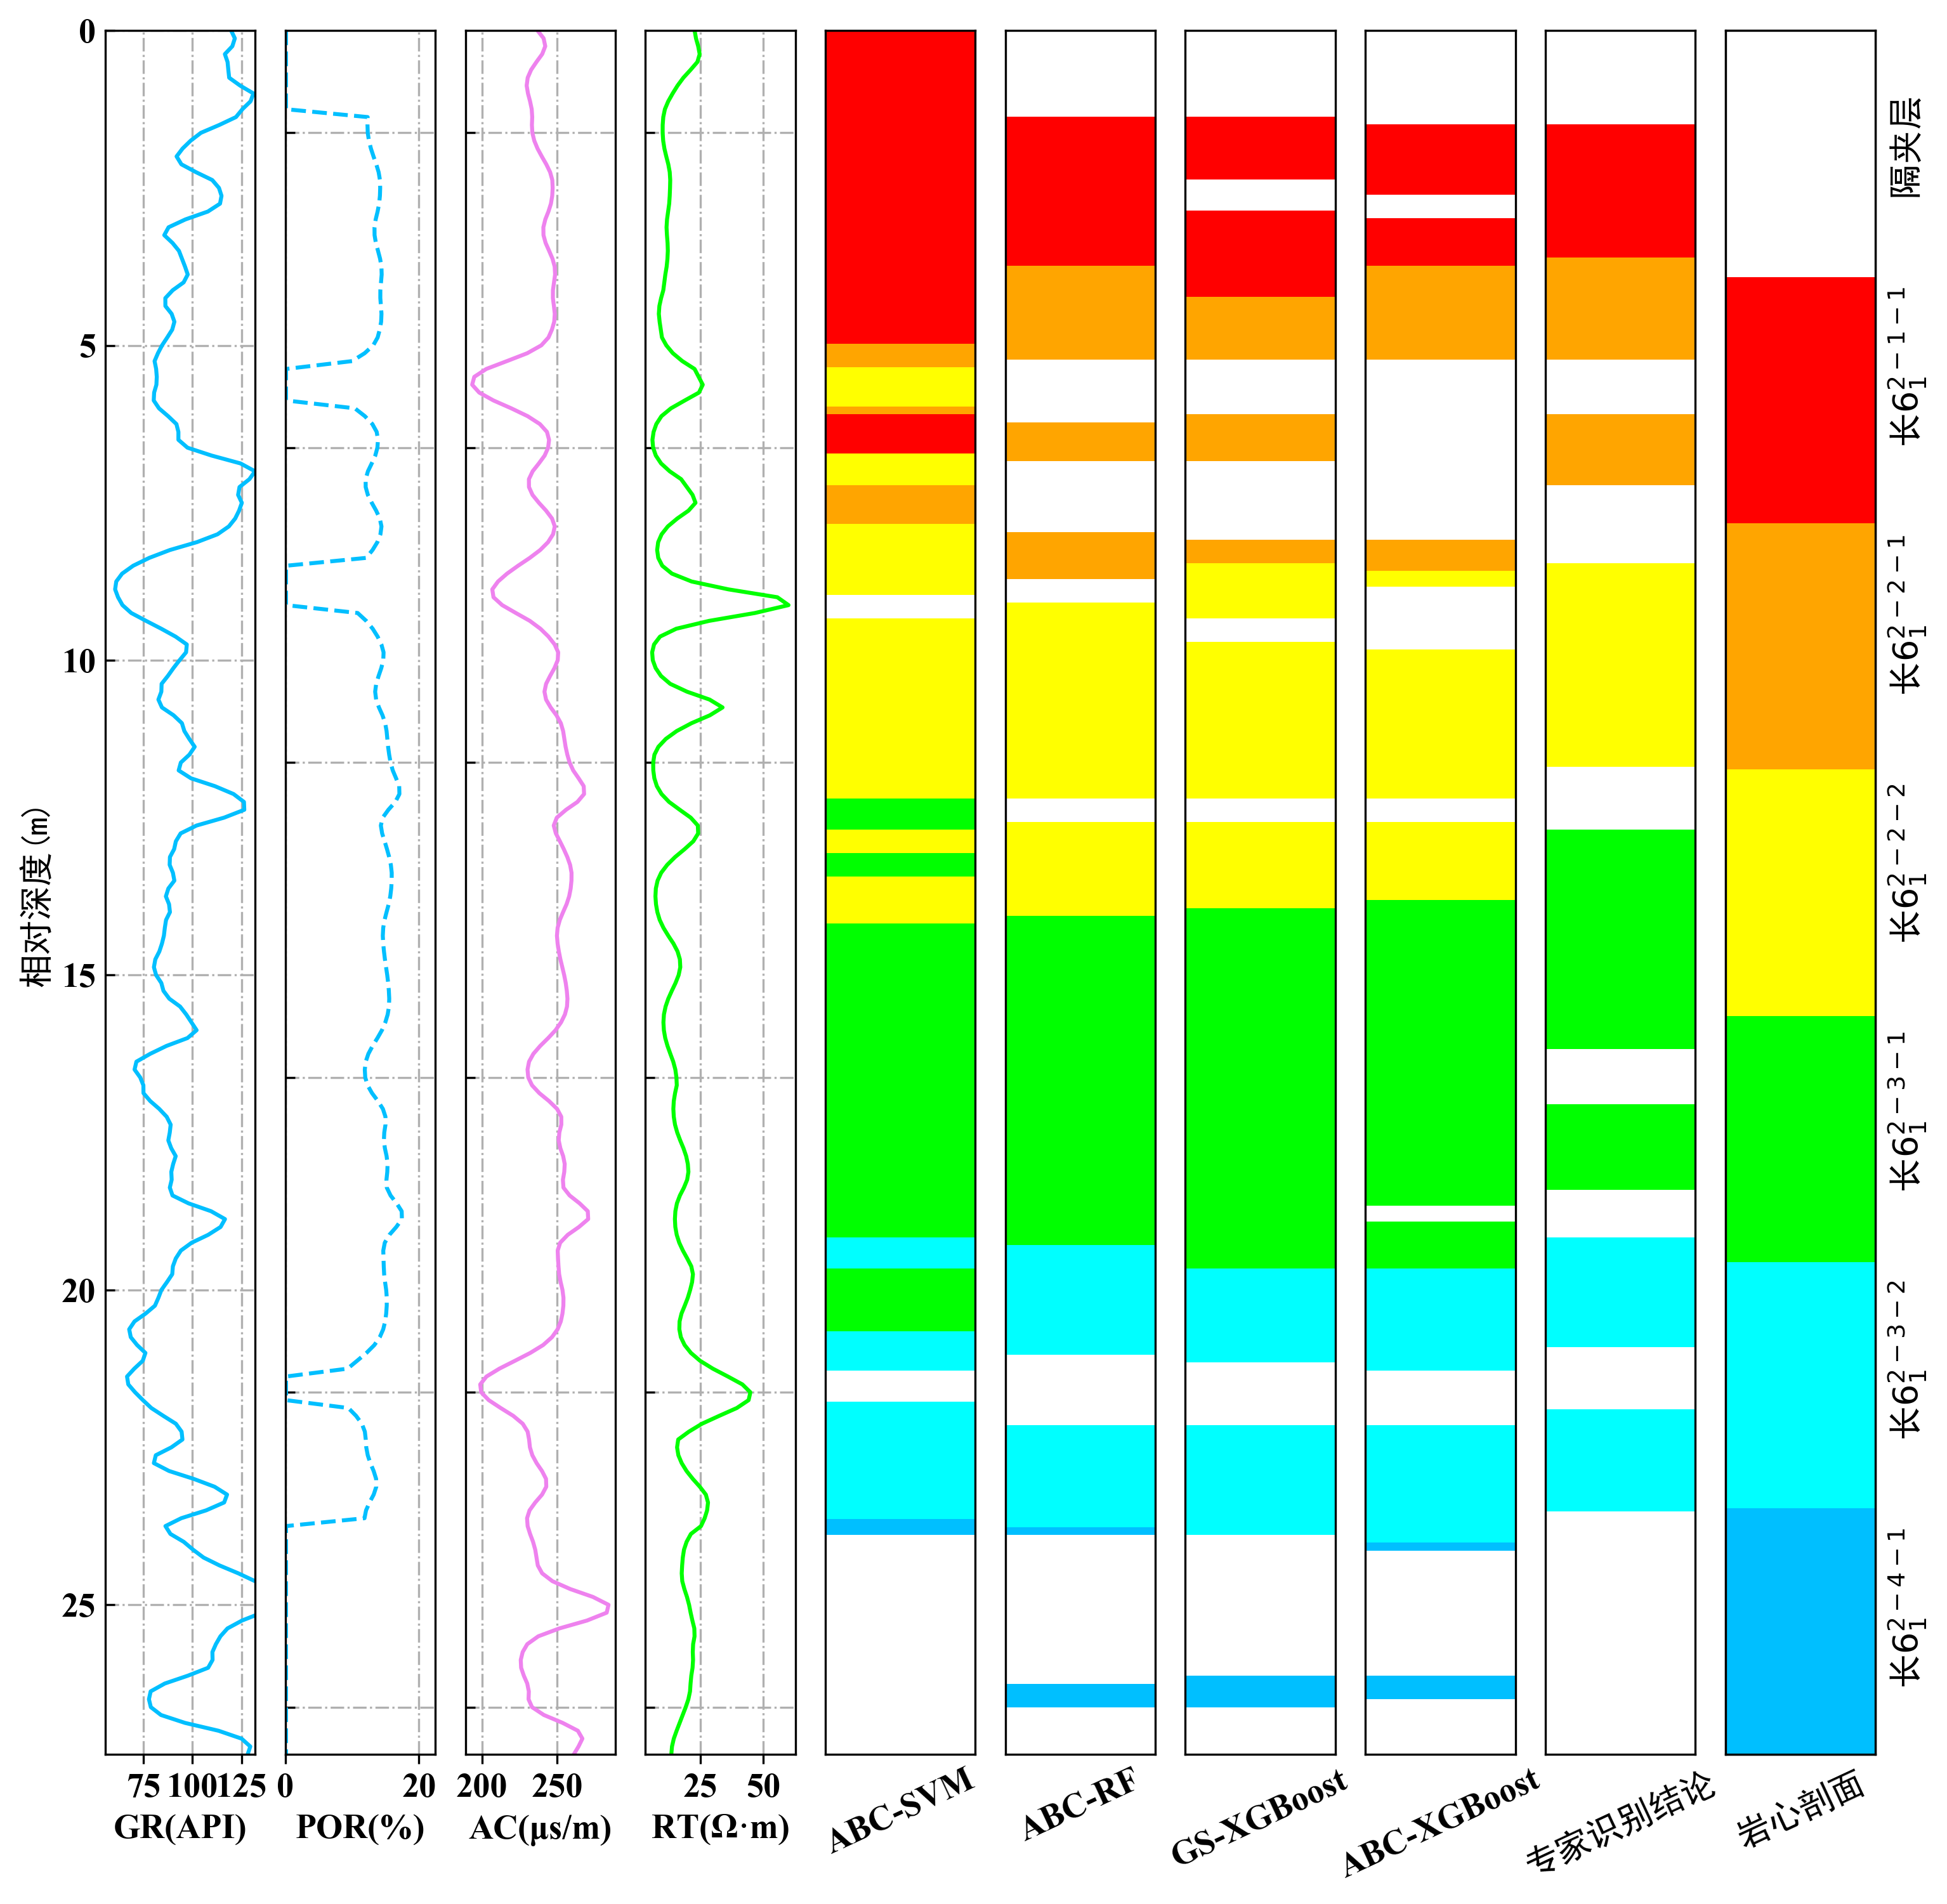

In [14]:
show_stage2_single_well(app_data,save=True)

## 应用于多井统计砂层厚度

在砂厚图应用中，同样按照两阶段对所有井进行识别
- 先利用一阶段模型识别出单砂体和隔夹层；
- 再在二阶段实验中将隔夹层的识别结论作为新的特征变量加入训练中

In [37]:
#统计元素数字总数，用来表示各层的层厚
def countX(dst, x):
    count = 0
    for point in dst:
        if (point == x):
            count = count + 1
    return count

In [25]:
_190_data = pd.read_csv('./整合后csv/190口单砂体数据V2_0.csv',encoding='utf-8')
STAGE2_CURVE =['mm_DEPTH','mm_GR','mm_SP','mm_RT','mm_AC','mm_POR','mm_PERM','mm_SW']
#以ABC_xgb的一阶段识别结果替换标准的隔夹层、单砂体标记
STAGE2_CURVE =['mm_DEPTH','mm_GR','mm_SP','mm_RT','mm_AC','mm_POR','mm_PERM','mm_SW']
_190_data['CHUC'] = _190_data['ABC_xgb1']
stage2_190X = _190_data[STAGE2_CURVE+['CHUC']]
answer = medfilt(ABC_xgb_2.predict(stage2_190X),kernel_size=5)
#把算出来的结论附为answer，并存入文件
_190_data['answer'] = answer
_190_data.to_csv('./整合后csv/190口单砂体数据及结论.csv',encoding='utf-8-sig',index=None)

In [41]:
#新的存档点
_190_data = pd.read_csv('./整合后csv/190口单砂体数据及结论.csv',encoding='utf-8')
wellname = _190_data.WELL_ID.unique().tolist()
WELL = []
for i in wellname:
    log = _190_data[_190_data.WELL_ID==i].reset_index(drop=True)
    answer = log['answer'].values
    c1 = countX(answer.tolist(),1)
    c2 = countX(answer.tolist(),2)
    c3 = countX(answer.tolist(),3)
    c4 = countX(answer.tolist(),4)
    c5 = countX(answer.tolist(),5)
    c6 = countX(answer.tolist(),6)
    #采样间隔为0.125m，即每两个点之间厚度为0.125m
    c1_length = c1*0.125
    c2_length = c2*0.125
    c3_length = c3*0.125
    c4_length = c4*0.125
    c5_length = c5*0.125
    c6_length = c6*0.125
    
    WELL.append([i,c1_length,c2_length,c3_length,c4_length,c5_length,c6_length])

In [43]:
WELL

[['DP10', 1.5, 4.375, 2.25, 3.75, 3.125, 0.625],
 ['DP3', 1.5, 3.25, 5.625, 2.375, 4.625, 3.625],
 ['ZJ47', 0.0, 1.375, 5.25, 4.0, 2.5, 0.0],
 ['ZJ65', 0.0, 3.25, 4.625, 4.0, 4.0, 0.0],
 ['天189', 1.5, 2.375, 5.375, 5.25, 2.875, 0.0],
 ['罗18-33', 2.25, 2.875, 4.75, 3.375, 2.875, 1.625],
 ['罗18-39', 1.125, 4.25, 3.25, 4.875, 1.75, 0.375],
 ['罗18-41', 2.25, 4.125, 5.125, 2.875, 2.875, 0.375],
 ['罗19-28', 0.0, 3.375, 3.75, 1.625, 0.0, 0.5],
 ['罗19-32', 2.625, 4.0, 3.375, 1.75, 0.0, 0.0],
 ['罗19-33', 0.0, 3.25, 5.0, 3.625, 2.375, 1.0],
 ['罗19-35', 0.0, 0.875, 3.375, 4.125, 2.75, 0.0],
 ['罗19-36', 3.25, 3.25, 5.375, 3.75, 4.125, 0.875],
 ['罗19-38', 1.0, 3.875, 3.75, 4.25, 3.0, 0.0],
 ['罗20-27', 0.0, 4.375, 4.125, 3.375, 1.375, 1.0],
 ['罗20-29', 1.875, 3.5, 4.0, 3.5, 1.875, 0.25],
 ['罗20-41', 0.75, 1.75, 3.875, 4.625, 3.0, 1.625],
 ['罗21-30', 2.0, 2.25, 0.875, 1.875, 1.375, 1.125],
 ['罗21-35', 0.0, 2.75, 5.625, 0.5, 0.0, 0.0],
 ['罗22-31', 0.5, 4.0, 3.375, 3.125, 3.25, 2.0],
 ['罗22-36', 1.875,

In [44]:
#保存至文件
pd.DataFrame(WELL).to_csv('./整合后csv/ABC-XGBoost砂厚图.csv',encoding='utf-8-sig',index=None)